# CASE BASED CLASSIFICATION

This notebook develops the idea of case base classiication (cb-clf). This involves:
1. Identify sets of feature that provide good classification accuracy. There may be many.
1. Given a new feature vector, provide evidence for the difference classes to which it may belong.

A **feature** is an atribtue of the data, like a Gene. A feature set is a collection of genes.
We typically write this as Rv3246c+Rv3260c.

A **feature vector** is a set of features with a value assigned. We are dealing with trinary values: -1 (under expressed),
+1 (over expressed), 0 (otherwise).
We typically write this as
Rv3246c[-1]+Rv3260c[0].

A **case** is a feature vector that effectively distinguishes between expression states (classes).

Cases are obtained from decision trees by examining nodes to see if their *impurity* (class distinctions) are statistically
significant.

Decision trees are obtained by running the Random Forest Classsification Algorithm.
This is done separately for each expression state.
So, in our data, there are 6 sets of cases.

Classifications are evaluated for new gene expression data by:
* Setup
   1. Construct cases for each expression state.
   
* Evaluation of a data set
   1. Create trinary data
   1. For each expression state
      1. Find applicable cases
      1. Plot their significance level

## Imports

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet
from common import trinary_data
from common_python.classifier.case_manager import FeatureVectorStatistic, Case, CaseManager

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

## Constants

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
FEATURES_NAMES = DF_X.columns.tolist()
NUM_TREE = 300

## Data

1. The data consistent of individual replicas of read counts at 26 times.
1. Times are labelled with six states, as defined in ``STATE_DCT``.
1. Raw expression values of normalized w.r.t. time 0 (normal) and transformed as log2 so that there are
25 normalized times that are trinary values defined as:
   * -1 if < -1
   * 1 if > 1
   * 0 otherwise

In [31]:
provider = DataProvider()
provider.do()
provider.df_go_terms.head()

GENE_ID                                            GO_Term
0  P9WKY5                                  host cell nucleus
1  Rv0001  DNA replication initiation---dephosphorylation...
2  Rv0002                   extracellular region---cell wall
3  Rv0003  double-strand break repair---cytosol---plasma ...
4  Rv0005  DNA topological change---growth---magnesium io...

In [51]:
df_terms = provider.df_go_terms.set_index("GENE_ID")
sel = [(g in DF_X.columns) and (df_terms.loc[g, "GO_Term"].find("fatty acid") > 0) for g in df_terms.index]
provider.df_go_terms[sel]

GENE_ID                                            GO_Term
76     Rv0117  regulation of fatty acid metabolic process---r...
304   Rv0445c  regulation of gene expression---regulation of ...
931    Rv1359  regulation of gene expression---regulation of ...
1306   Rv1956  response to hypoxia---regulation of fatty acid...
1340   Rv2017  regulation of fatty acid metabolic process---r...
1341  Rv2021c  regulation of fatty acid metabolic process---r...
1350   Rv2034  regulation of transcriptionDNA-templated---reg...
1826  Rv2745c  response to oxidative stress---response to hea...
2102  Rv3133c  response to hypoxia---pathogenesis---regulatio...
2123  Rv3164c  regulation of fatty acid metabolic process---c...
2279  Rv3414c  pathogenesis---response to heat---regulation o...
2280   Rv3416  pathogenesis---regulation of lipid metabolic p...
2367  Rv3557c  regulation of transcriptionDNA-templated---reg...
2560   Rv3833  regulation of fatty acid metabolic process---m...

In [3]:
STATE_DCT = {}
STATE_DCT[0] = "Normoxia"
STATE_DCT[1] = "Transition"
STATE_DCT[2] = "Stage II"
STATE_DCT[3] = "Stage 1a"
STATE_DCT[4] = "Stage 1b"
STATE_DCT[5] = "Resuscitation"
STATE_DCT

{0: 'Normoxia',
 1: 'Transition',
 2: 'Stage II',
 3: 'Stage 1a',
 4: 'Stage 1b',
 5: 'Resuscitation'}

In [4]:
CASE_MANAGER_DCT = CaseManager.mkCaseManagers(DF_X, SER_Y, n_estimators=NUM_TREE)

In [5]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM_MDM = SAMPLE_DATA.AM_MDM.T
DF_AW = SAMPLE_DATA.AW.T
DF_GALAGAN = SAMPLE_DATA.galagan.T
DF_SHERMAN = SAMPLE_DATA.sherman.T
DF_RUSTAD = SAMPLE_DATA.rustad.T

In [6]:
DF_AW

AW_plus_1  AW_neg_1  AW_plus_3  AW_neg_3  AW_plus_4  AW_neg_4
GENE_ID                                                               
Rv2069           0         0          0         0          0         0
Rv1773c         -1         0         -1        -1         -1        -1
Rv3249c          0         0          0         0          0         0
Rv2595           0         0          1         0          1         0
Rv1049          -1        -1         -1        -1          0        -1
...            ...       ...        ...       ...        ...       ...
Rv0602c         -1        -1         -1        -1         -1        -1
Rv0880          -1        -1         -1        -1         -1        -1
Rv2827c          0        -1         -1         0         -1         0
Rv3164c          0         1          1         1          1         0
Rv0117           0        -1          0         0          0         0

[102 rows x 6 columns]

In [7]:
manager = CASE_MANAGER_DCT[1]
len(manager.case_dct)

546

## Helper Functions

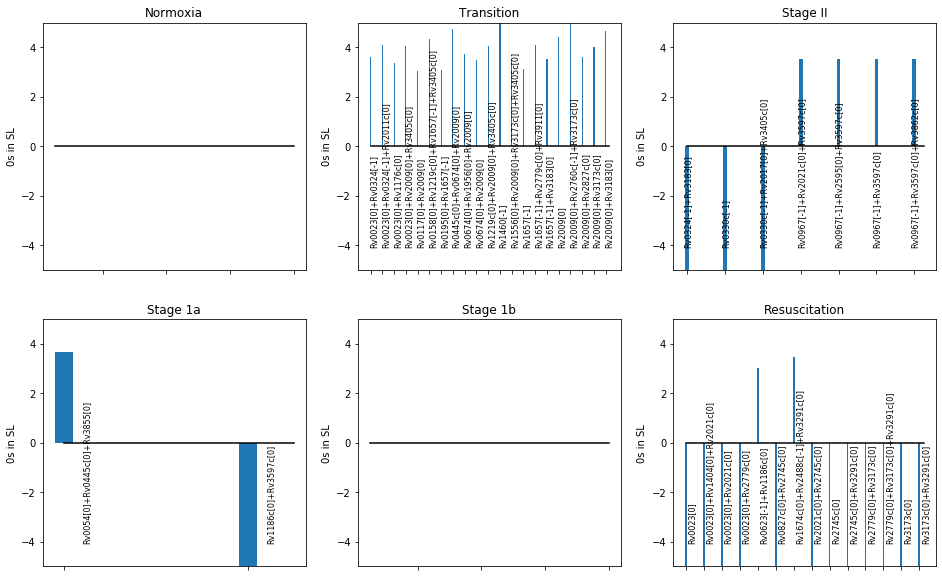

In [15]:
 def fullProfile(ser_X, title="", max_sl=0.001, **kwargs):
        """
        Creates a classification profile for the feature vector.
        
        Parameters
        ----------
        ser_X: Series (feature vector)
        """
        kwargs["max_sl"] = max_sl
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            manager = CASE_MANAGER_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            cases = manager.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = STATE_DCT[idx],
                label_xoffset=label_xoffset, **kwargs)
        fig.suptitle(title, fontsize=16)
        plt.show()
        
# Tests
ser_X = DF_X.loc["T2.1"]
fullProfile(ser_X, max_sl=0.001)

# Miscellaneous Calculations

## Case Calculations

Given a maximum significance level $\alpha$, a sample size of $N$, and null distribution that is Binomial in $(N, p)$,
what is the minimum sample size?

We want $N$ such that $P(n = N) = P(n = 0) \leq \alpha$.
That is, $\alpha \geq p^N \equiv \frac{log(\alpha)}{log(p)} \leq N$.

# Evaluations of Samples

## Training Data

A feature vector evaluation involves finding all cases that apply to the feature vector
and indicating their support for or against a particular state.

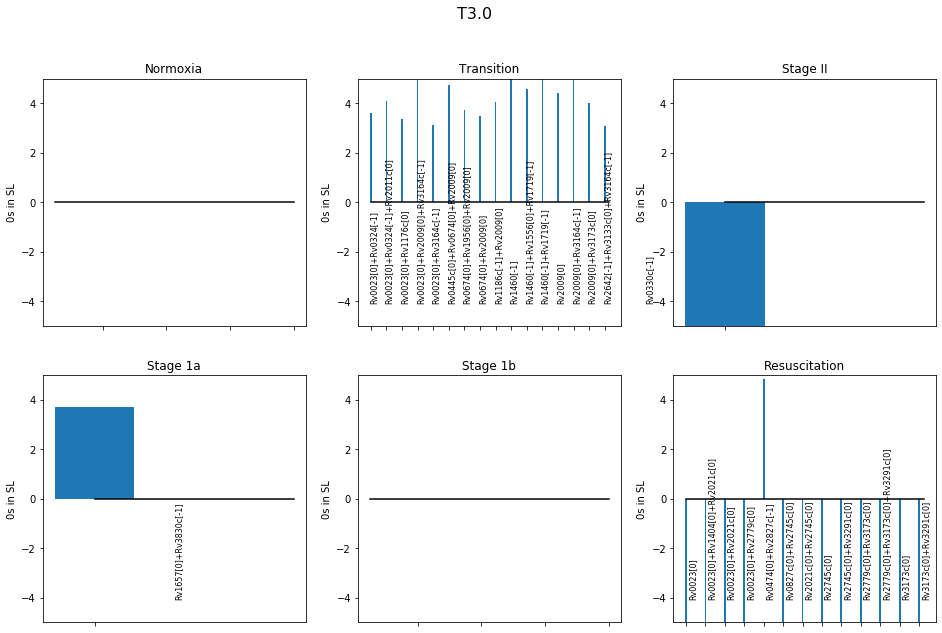

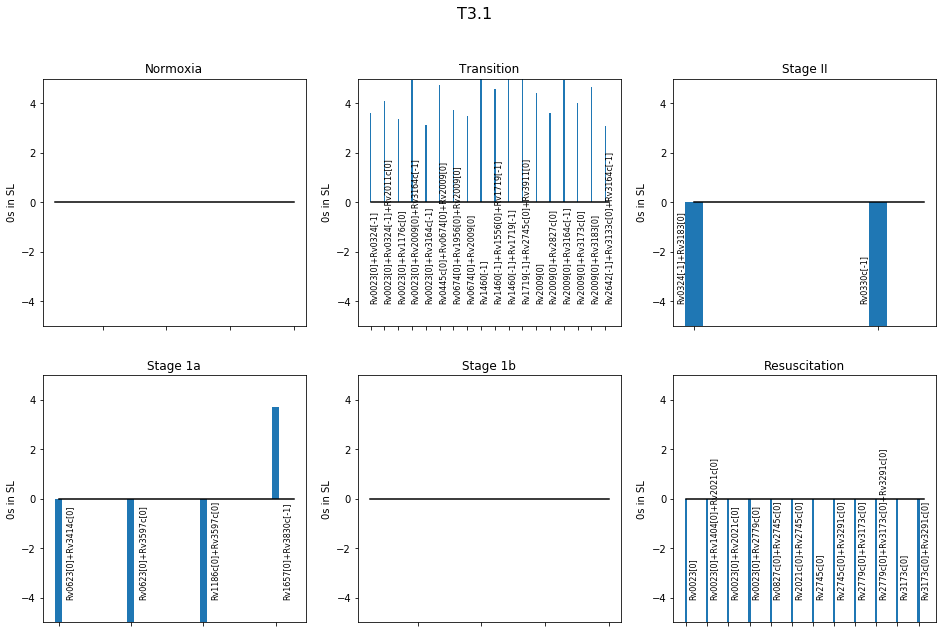

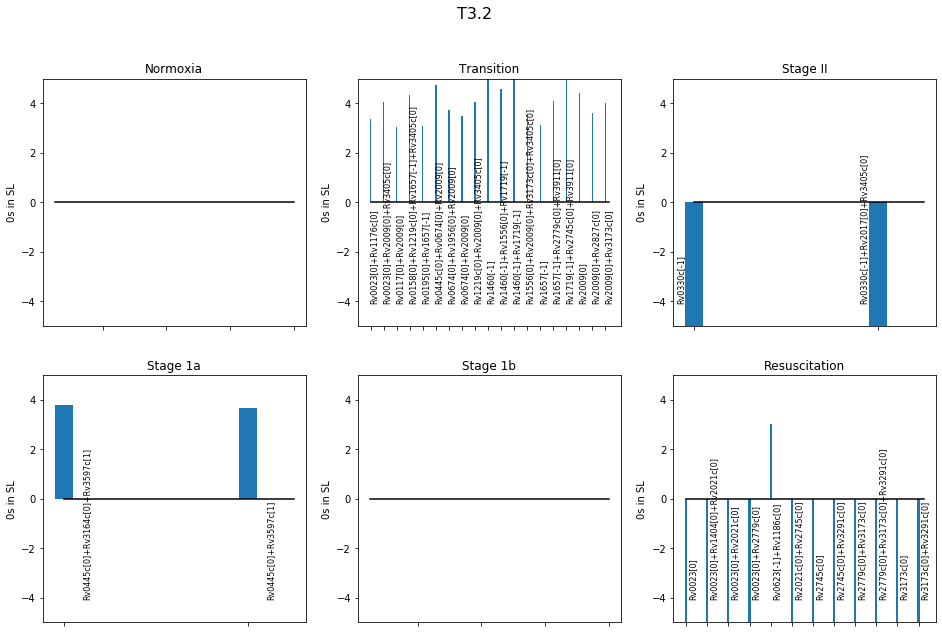

In [16]:
# Below is a evaluation of the feature vector at the first replication at time T3.
instances = ["T3.0", "T3.1", "T3.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

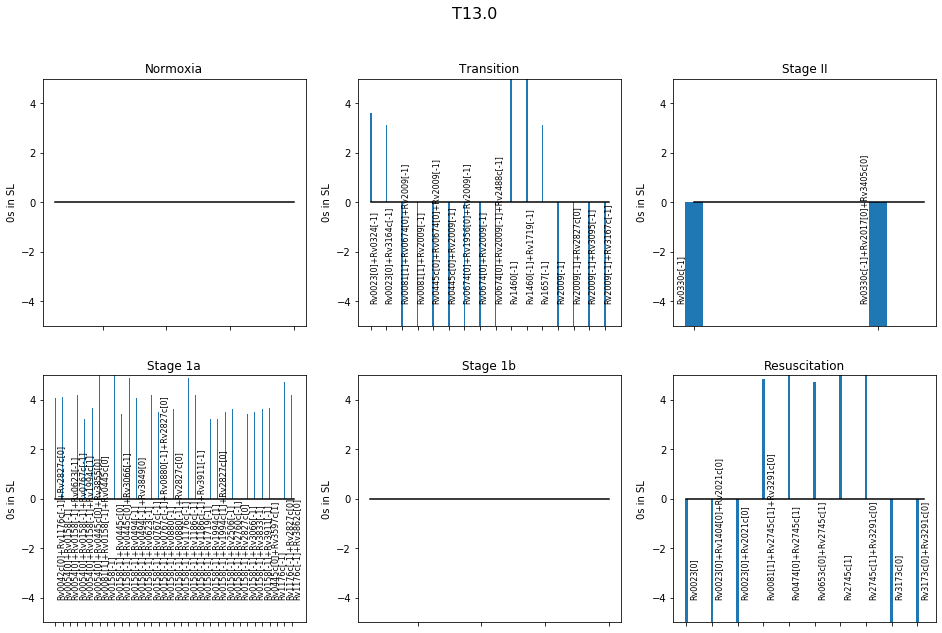

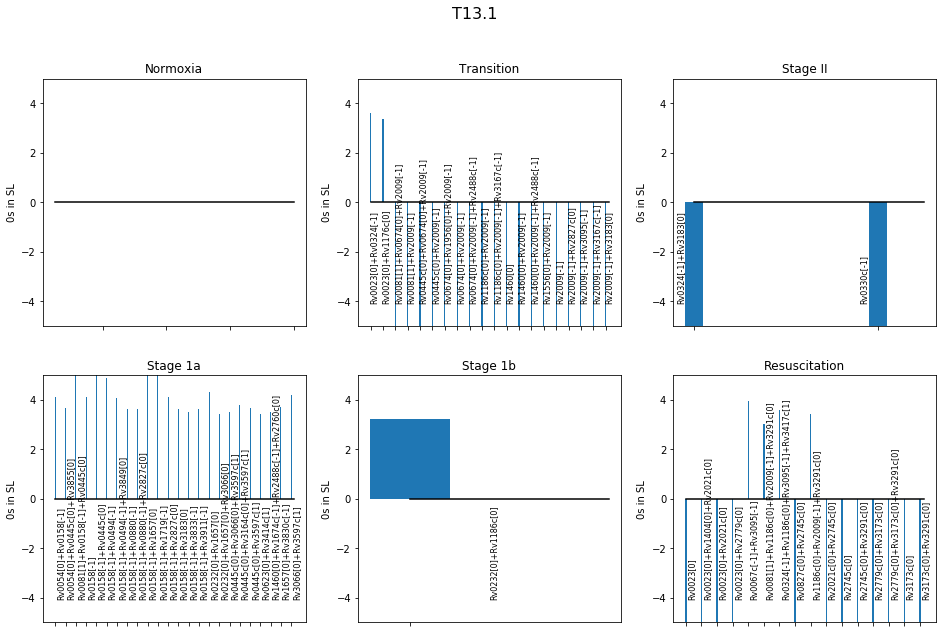

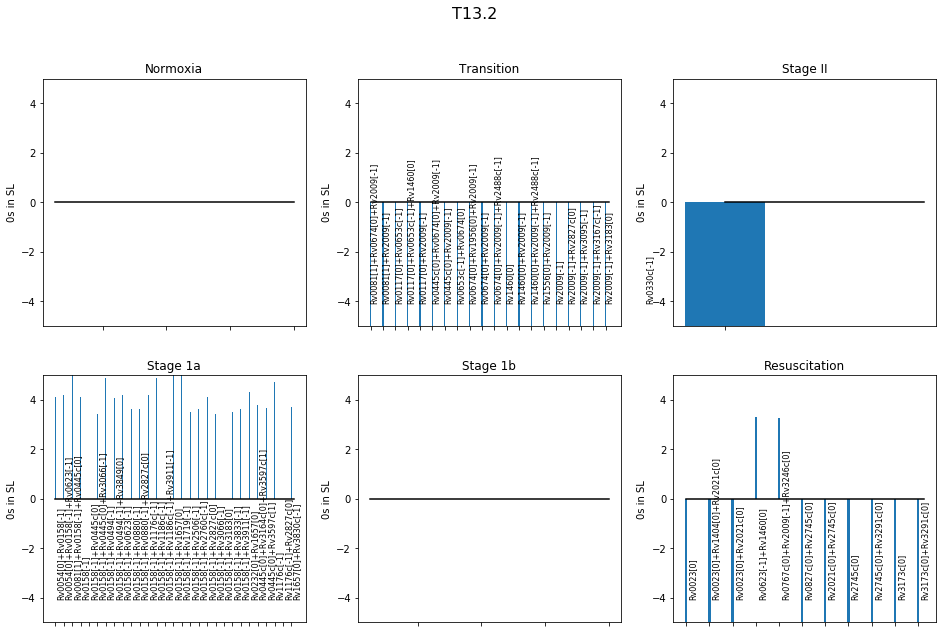

In [27]:
instances = ["T13.0", "T13.1", "T13.2"]
for instance in instances:
    fullProfile(DF_X.loc[instance], title=instance)

## AW

In [17]:
DF_AW.head(2)

AW_plus_1  AW_neg_1  AW_plus_3  AW_neg_3  AW_plus_4  AW_neg_4
GENE_ID                                                               
Rv2069           0         0          0         0          0         0
Rv1773c         -1         0         -1        -1         -1        -1

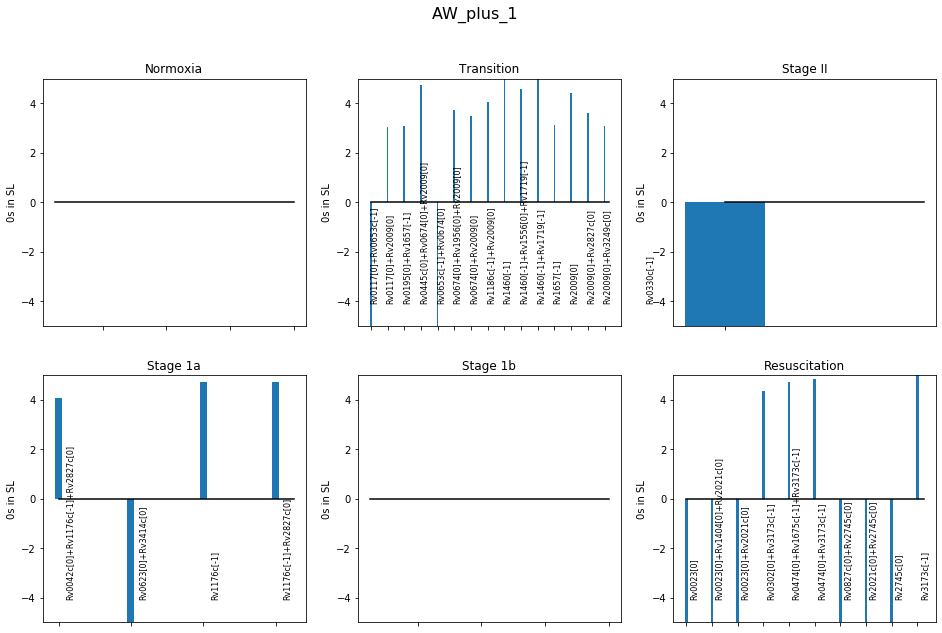

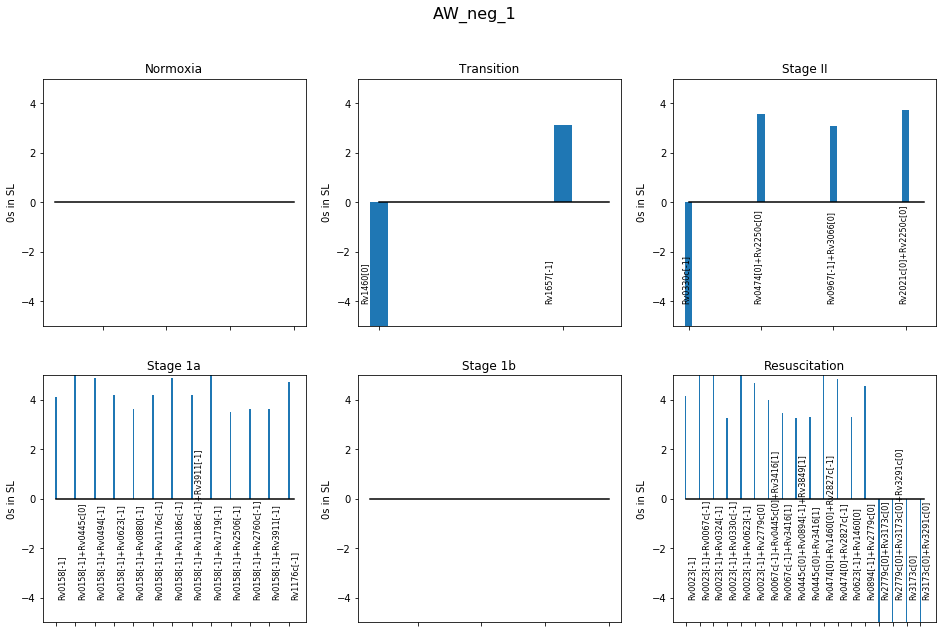

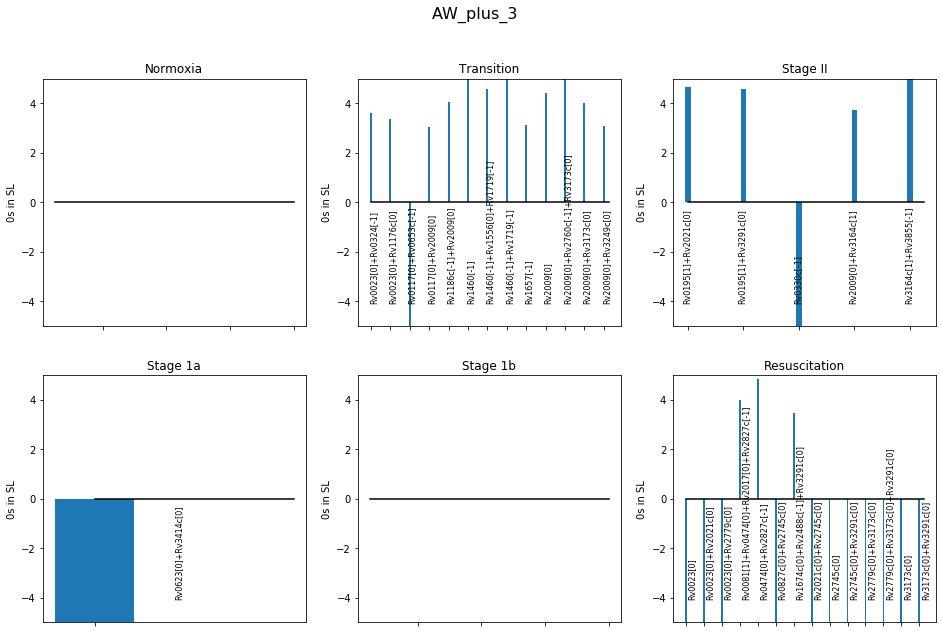

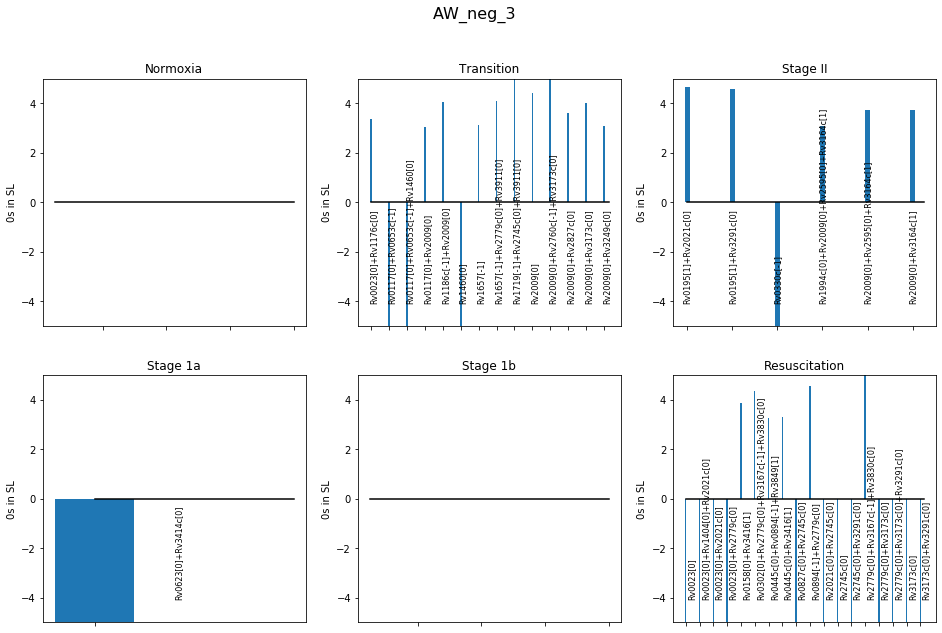

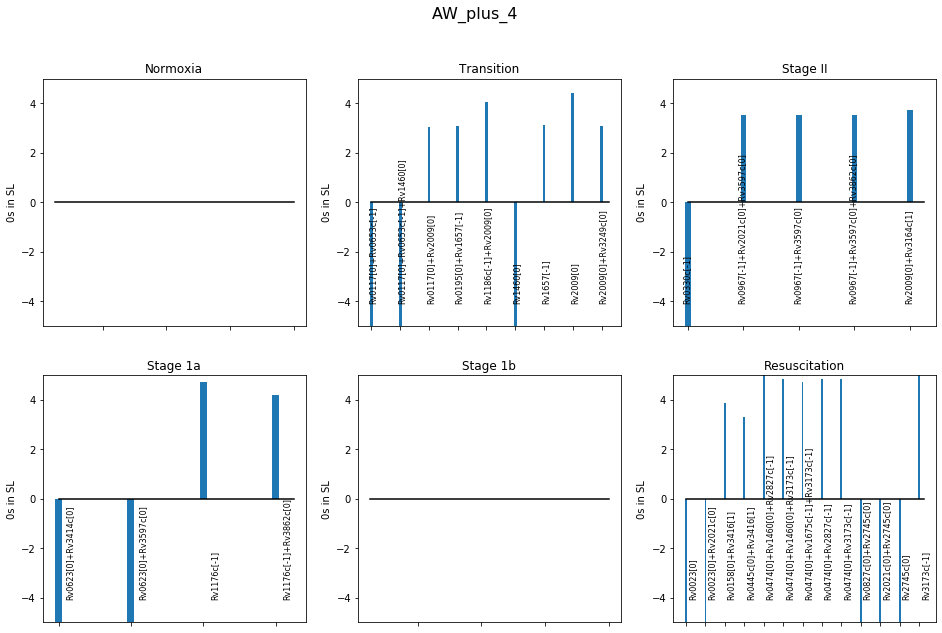

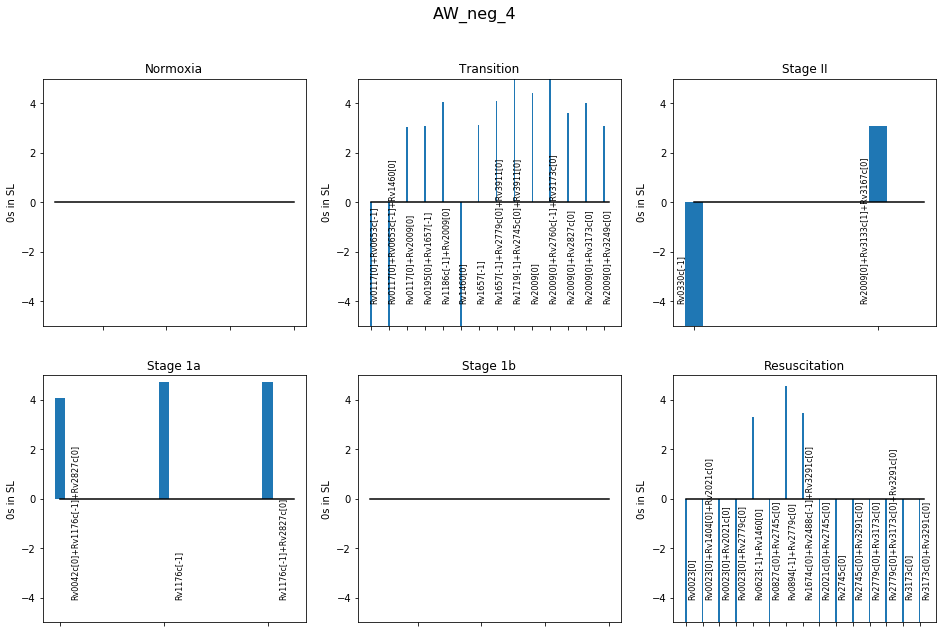

In [18]:
instances = [ ["AW_%s_%d" % (pm, n) for pm in ["plus", "neg"]] for n in [1, 3, 4]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AW[instance], title=instance)

## AM, MDM

In [19]:
DF_AM_MDM.head(2)

AM_D20_1  AM_D20_3  AM_D20_4  AM_D20_5  MDM_D20_1  MDM_D20_3  \
GENE_ID                                                                 
Rv2069         -1        -1        -1        -1          0          0   
Rv1773c        -1        -1        -1         0         -1         -1   

         MDM_D20_4  MDM_D20_5  
GENE_ID                        
Rv2069           0         -1  
Rv1773c         -1         -1

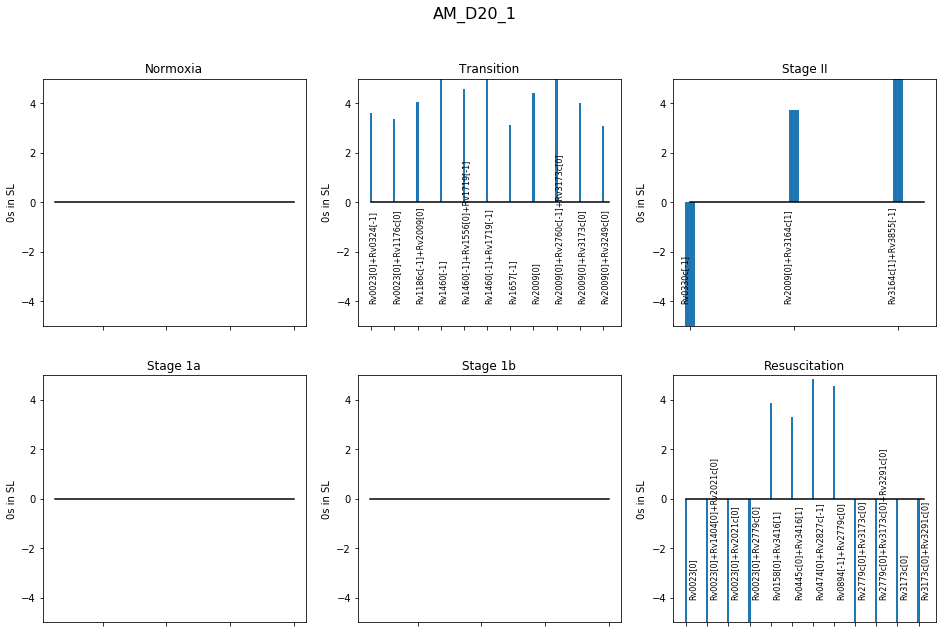

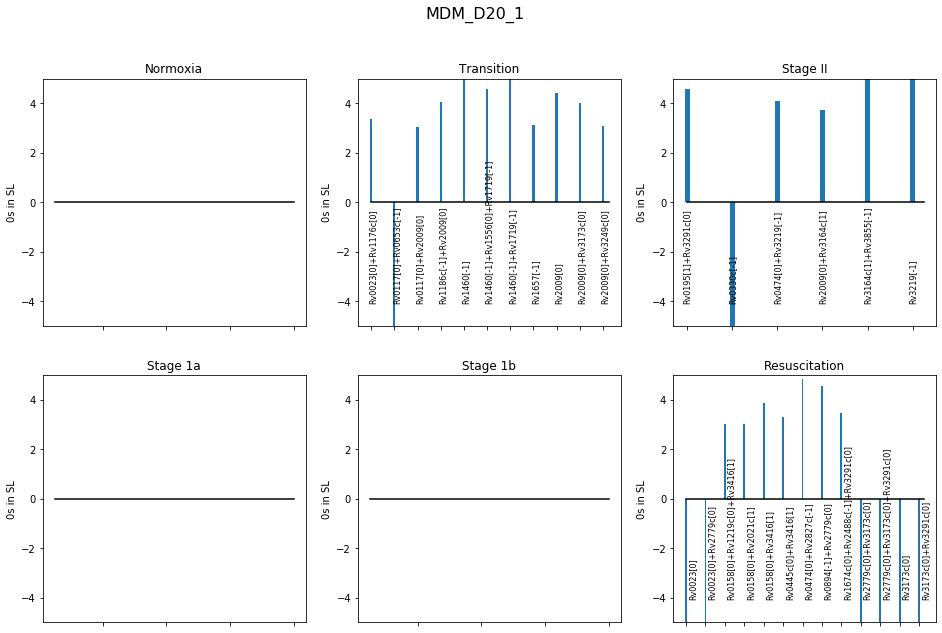

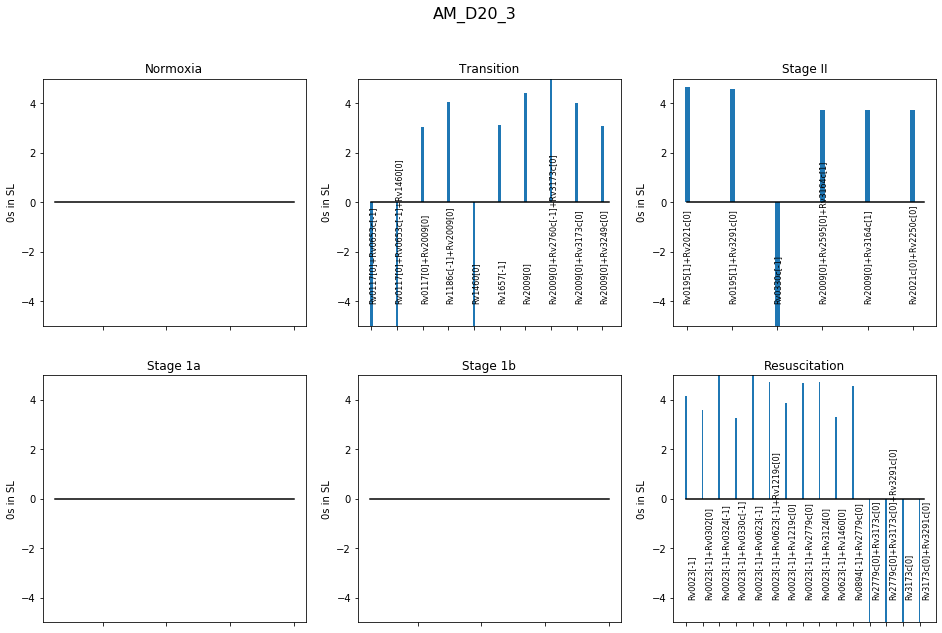

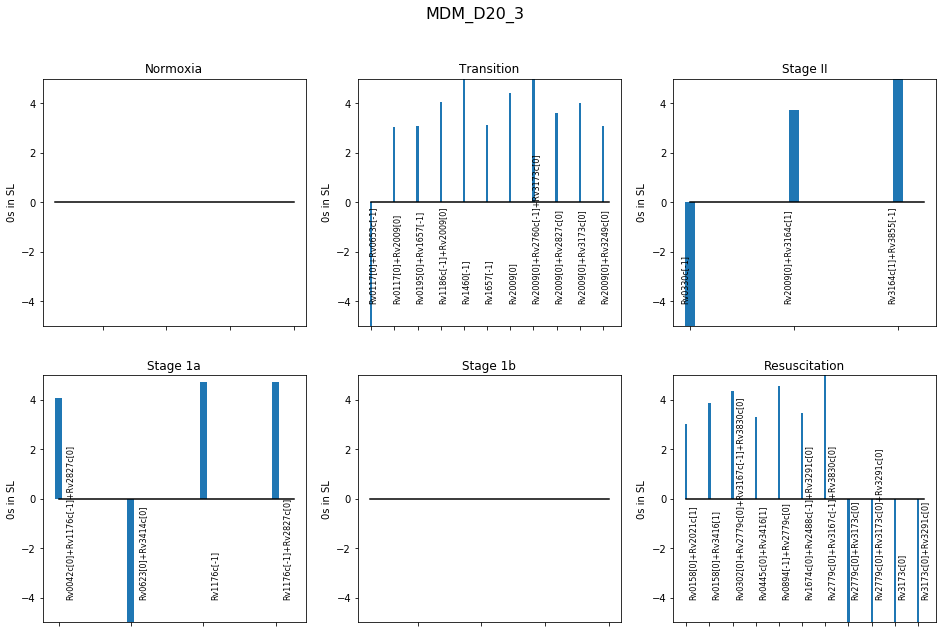

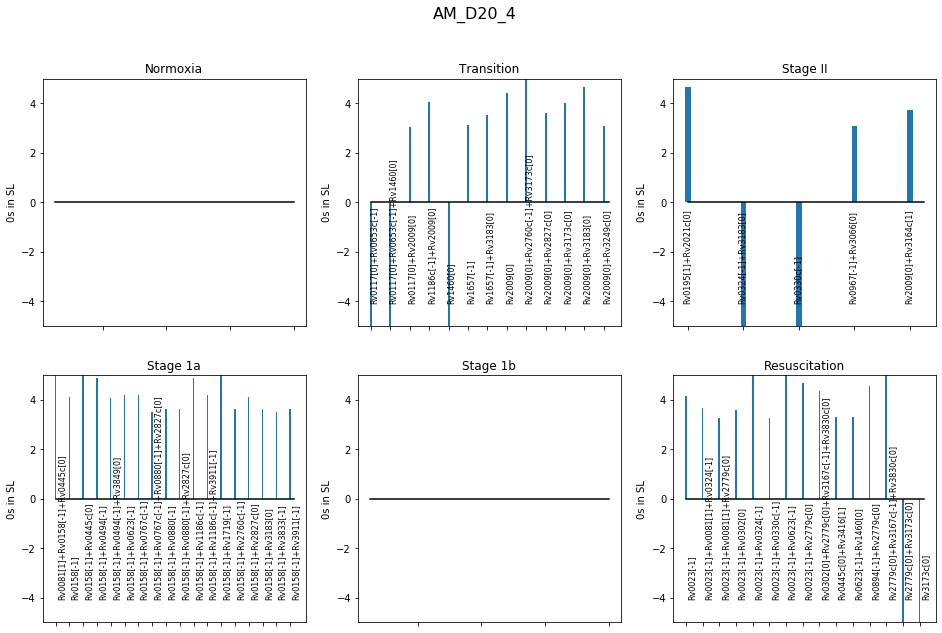

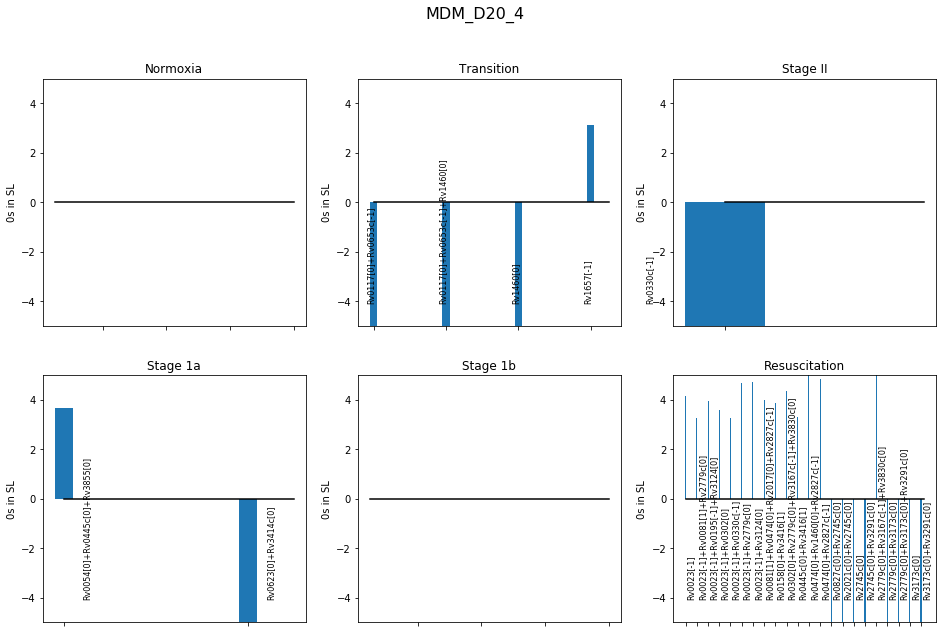

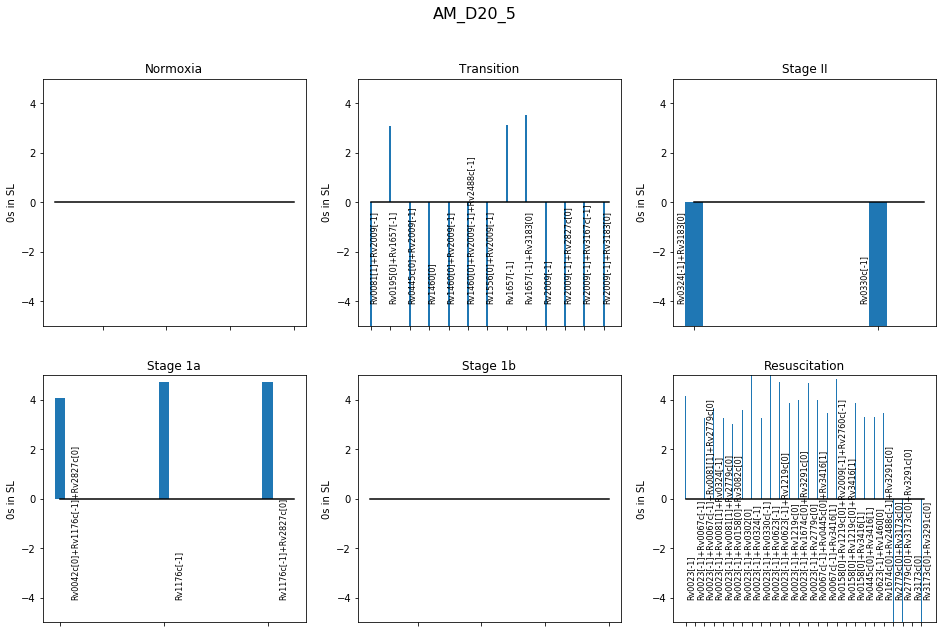

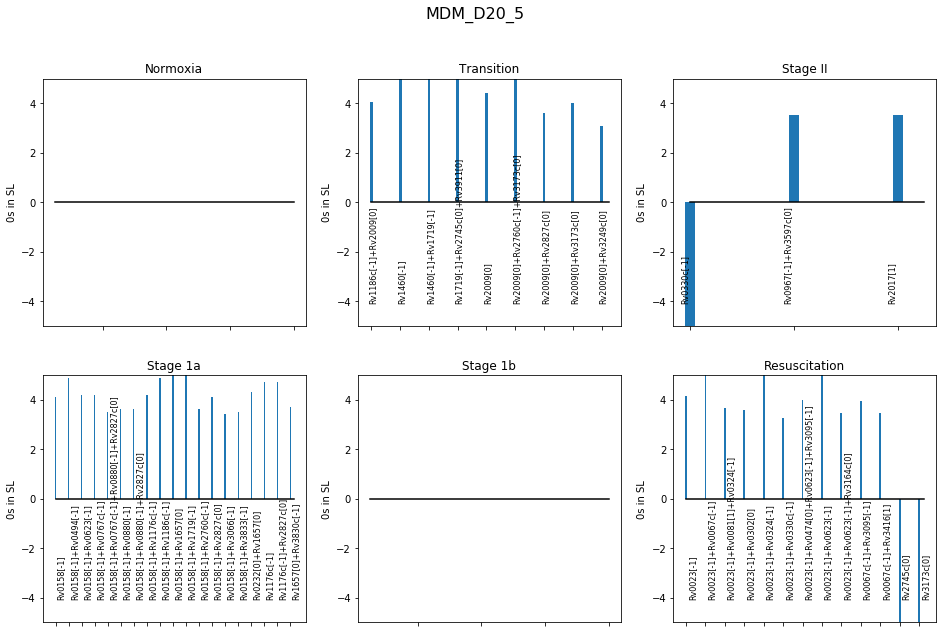

In [20]:
instances = [ ["%s_D20_%d" % (pm, n) for pm in ["AM", "MDM"]] for n in [1, 3, 4, 5]]
instances = list(np.array(instances).flatten())
for instance in instances:
    fullProfile(DF_AM_MDM[instance], title=instance)

## Galagan

In [21]:
DF_GALAGAN.head(2)

d1.rep1  d2.rep1  d3.rep1  d5.rep1  d7.rep1  d8.rep1  d1.rep2  \
GENE_ID                                                                  
Rv0576         0        0        0        0       -1       -1        0   
Rv0691c        0        0        0        0        0        0        0   

         d2.rep2  d3.rep2  d5.rep2  d7.rep2  d8.rep2  d1.rep3  d2.rep3  \
GENE_ID                                                                  
Rv0576         0        0       -1        0       -1        0        0   
Rv0691c        0        0        0        0        0        0        0   

         d3.rep3  d5.rep3  d7.rep3  d8.rep3  
GENE_ID                                      
Rv0576         0        0       -1       -1  
Rv0691c        0        0        0        0

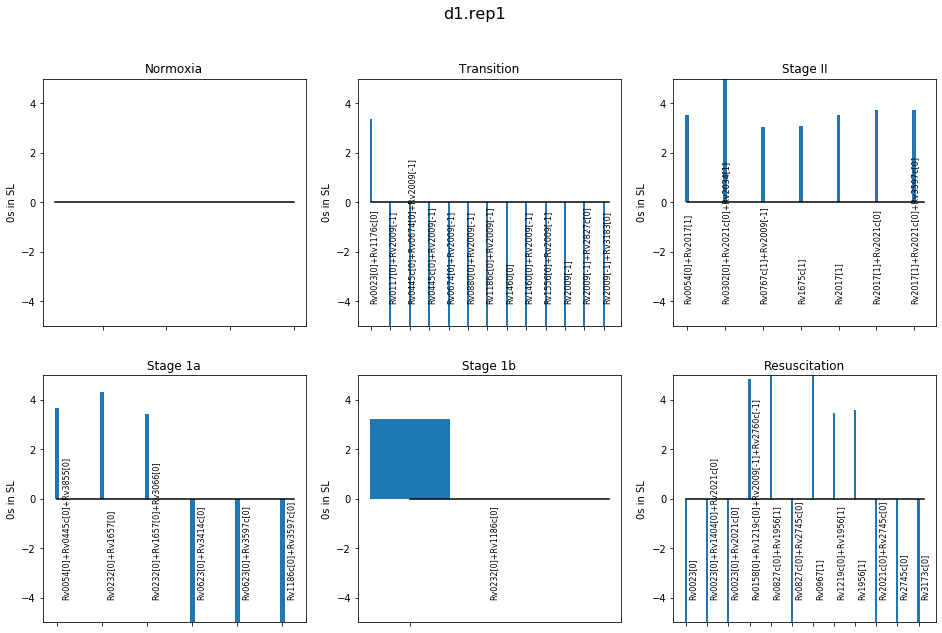

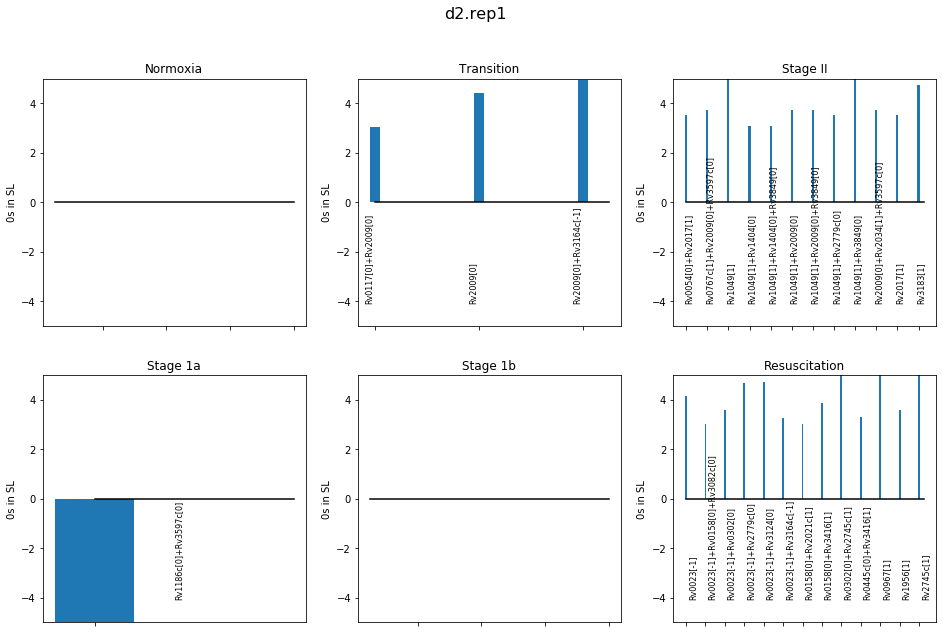

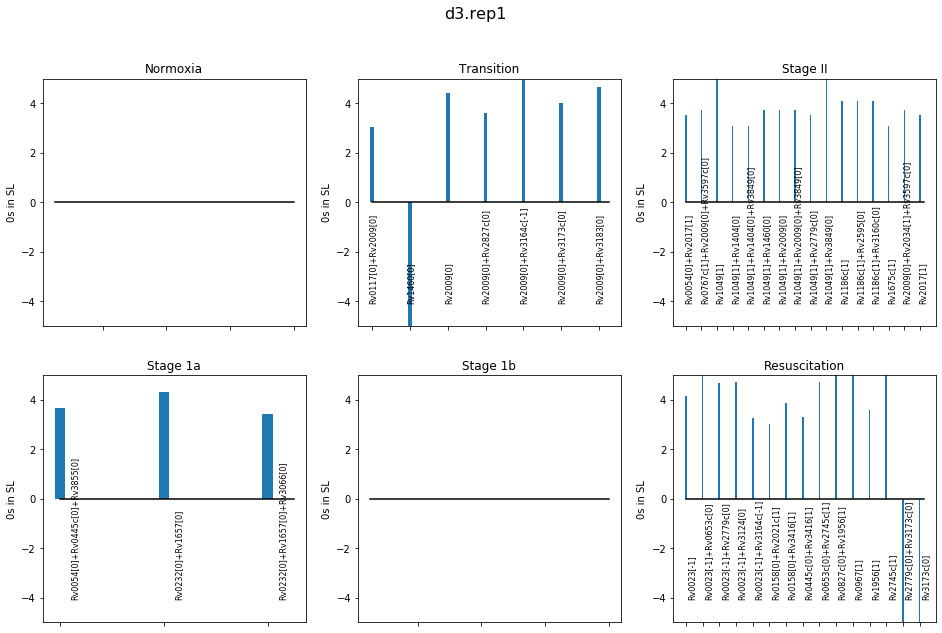

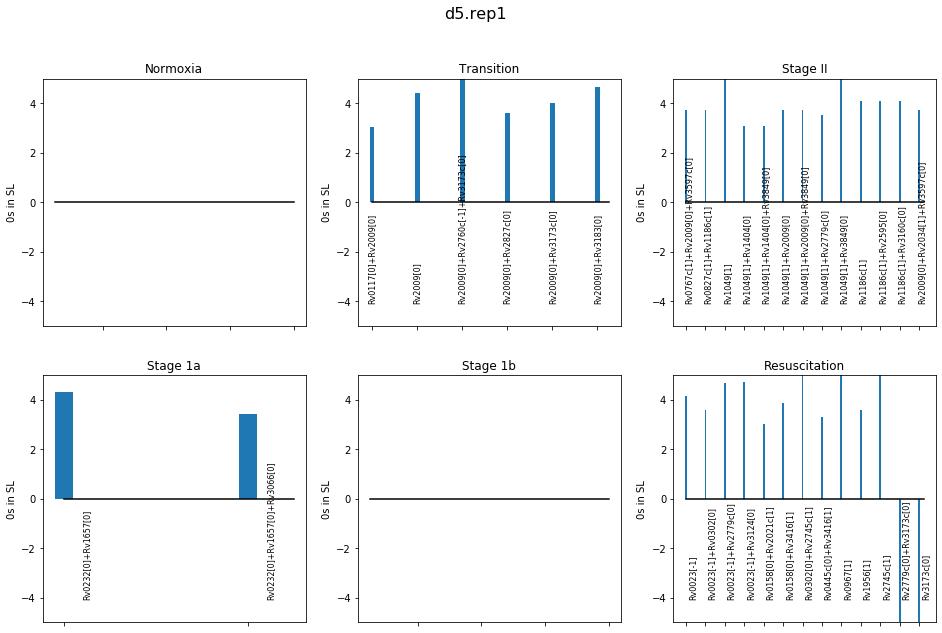

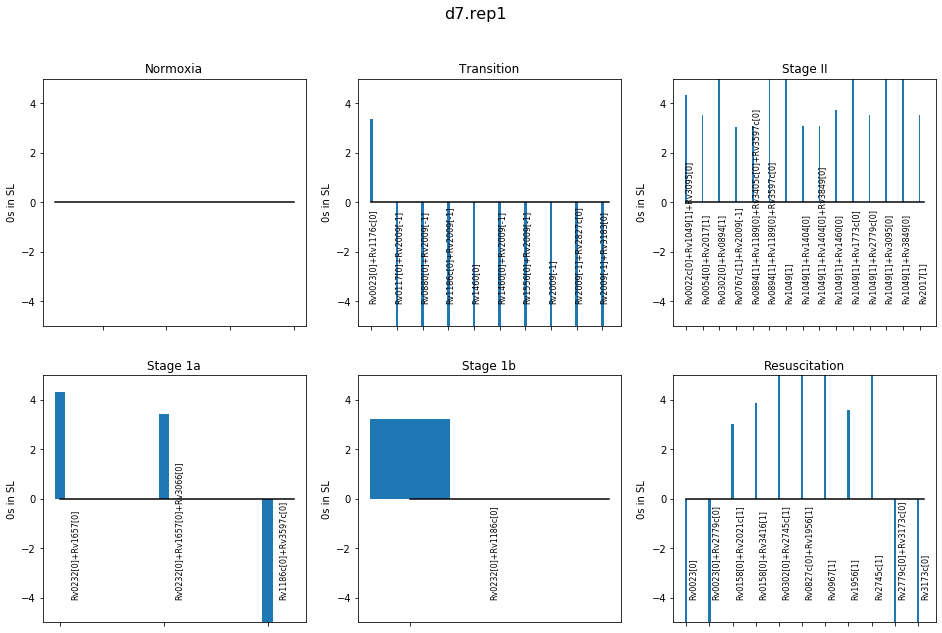

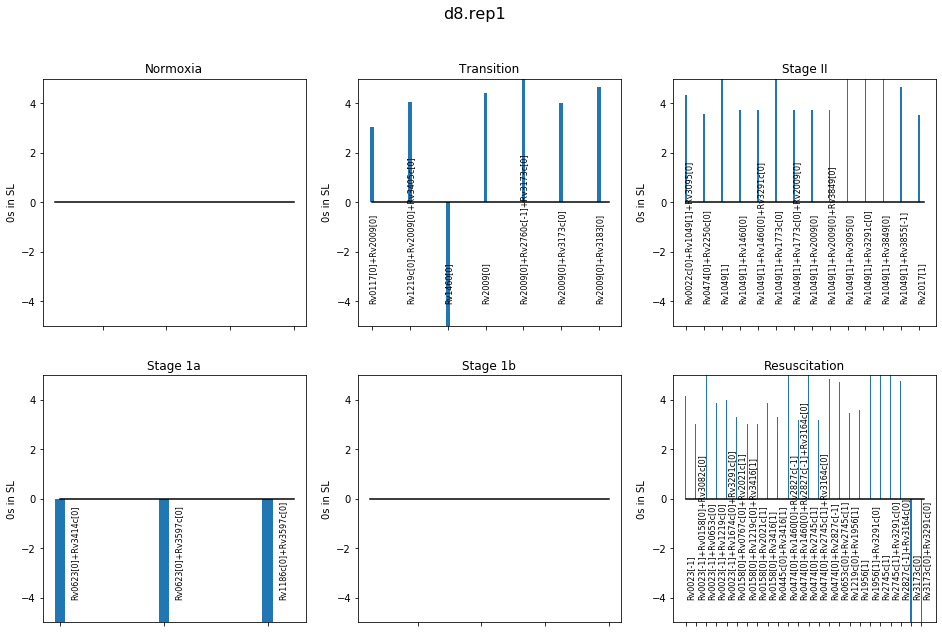

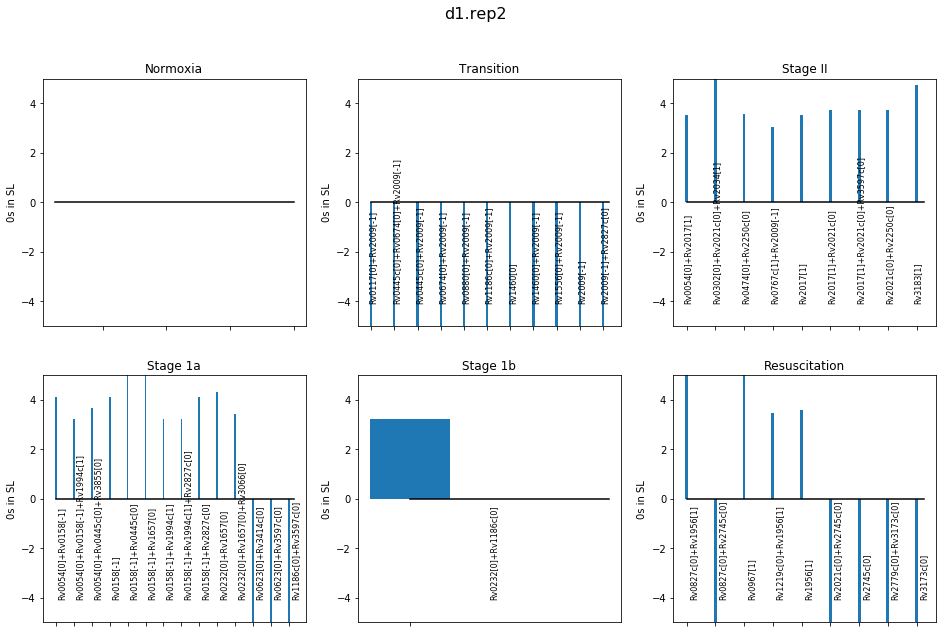

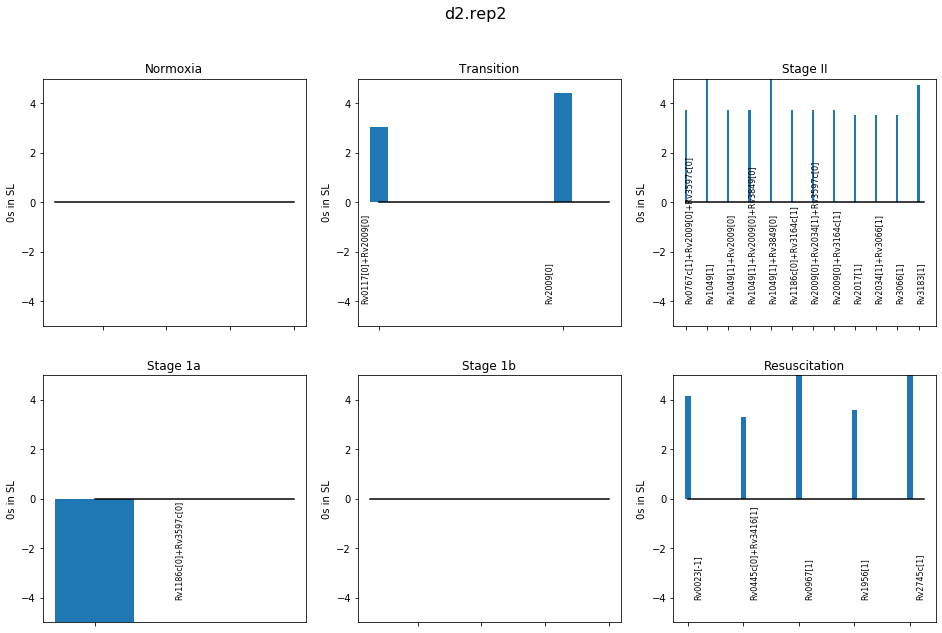

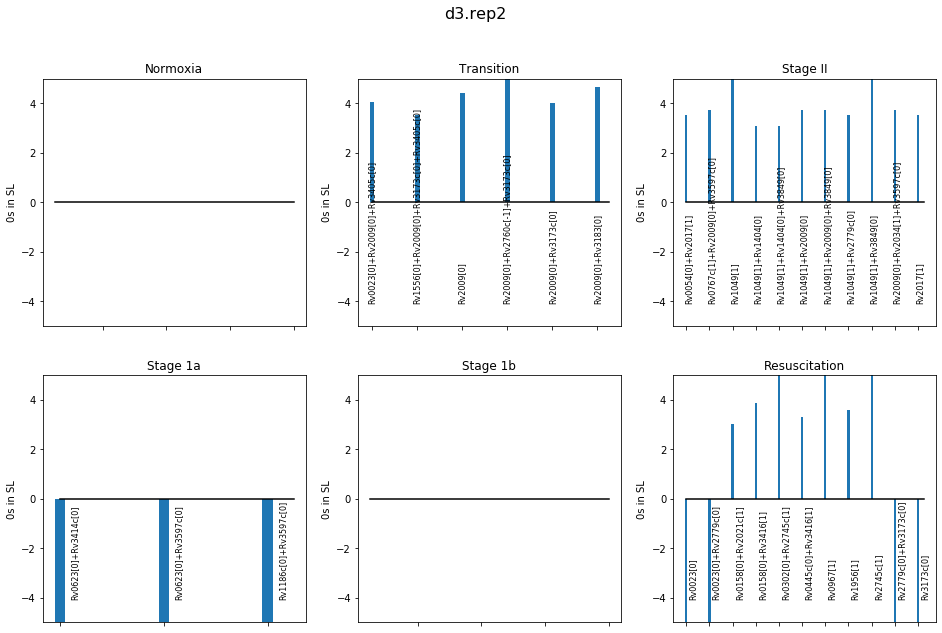

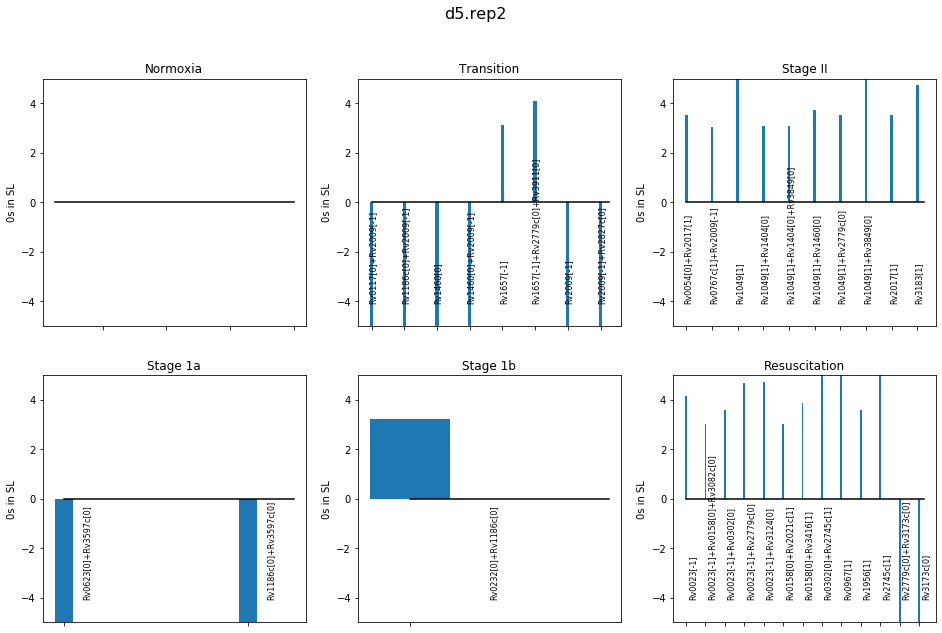

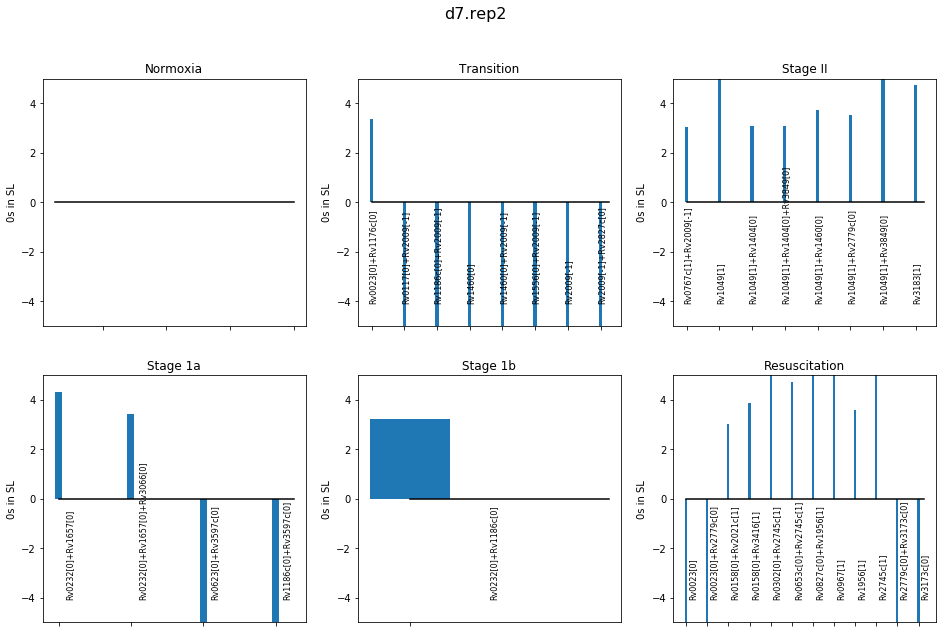

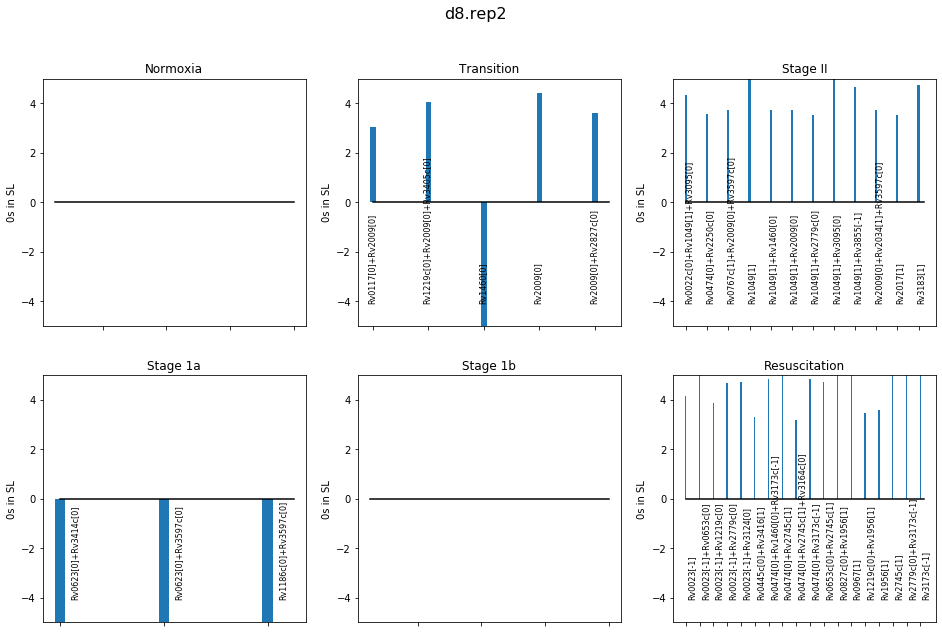

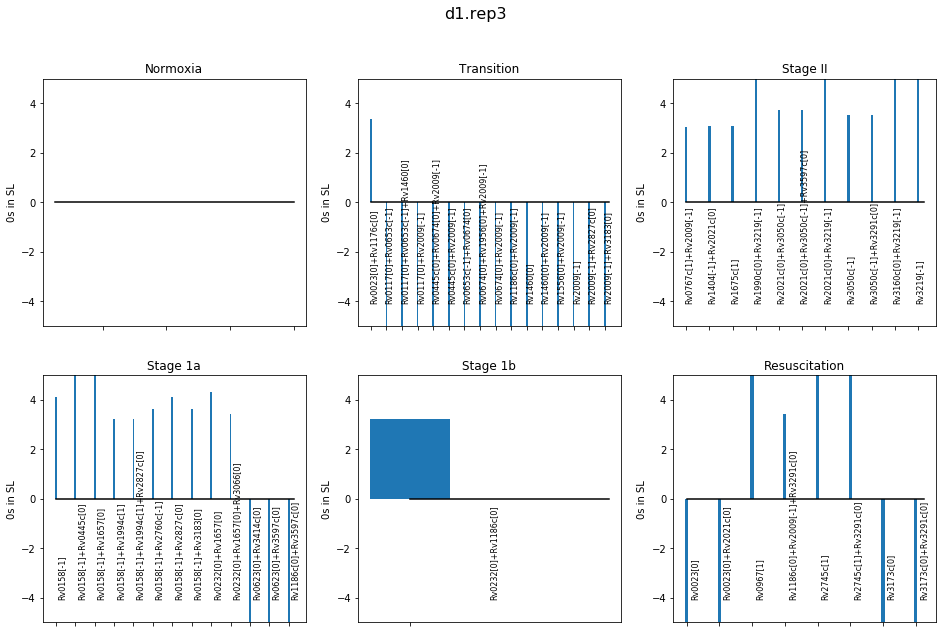

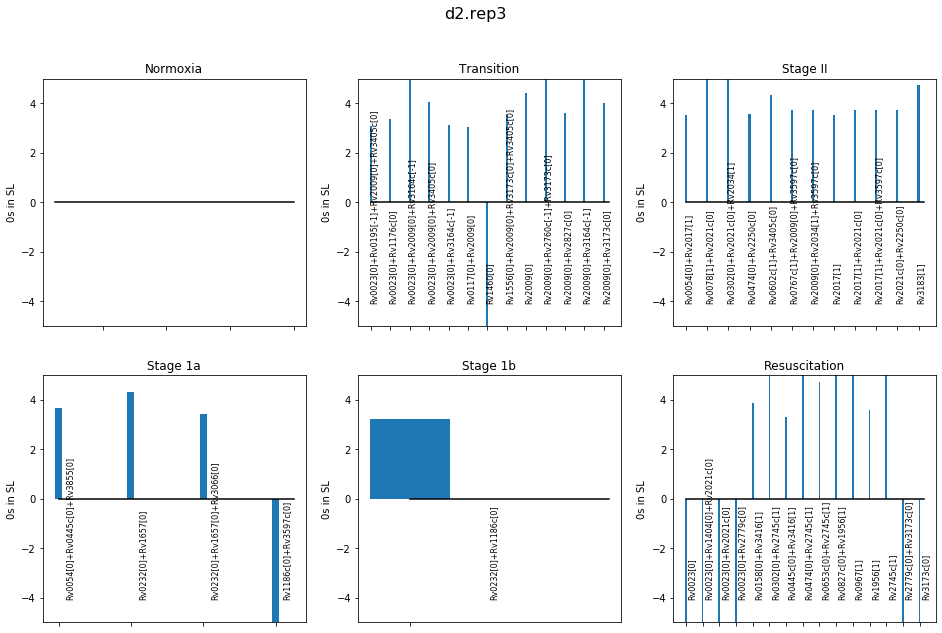

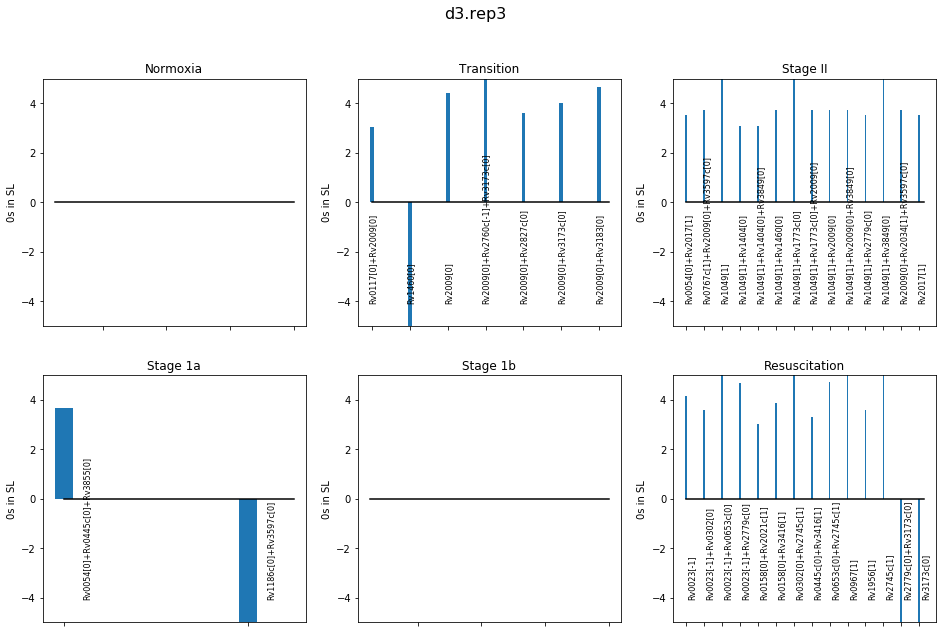

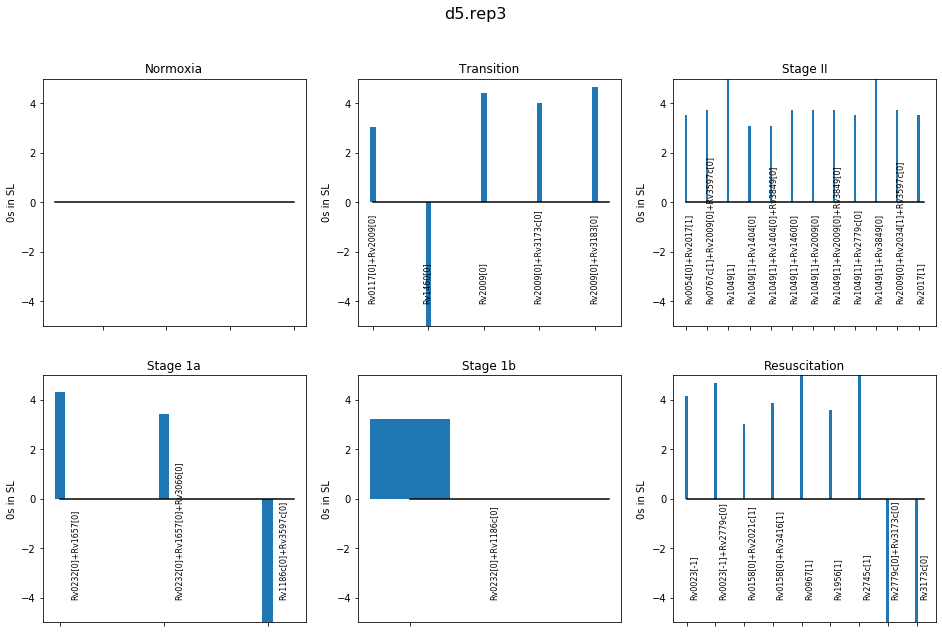

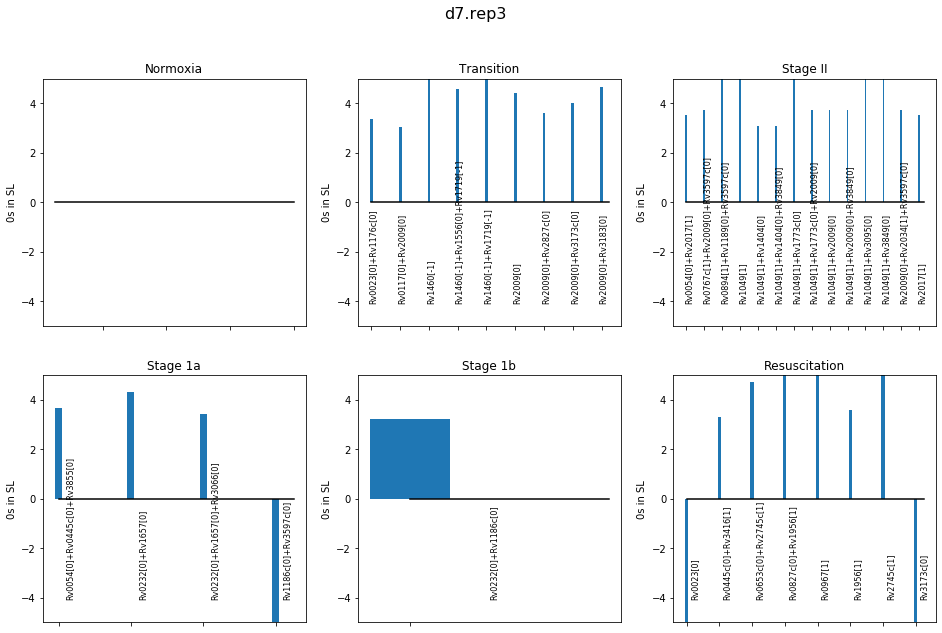

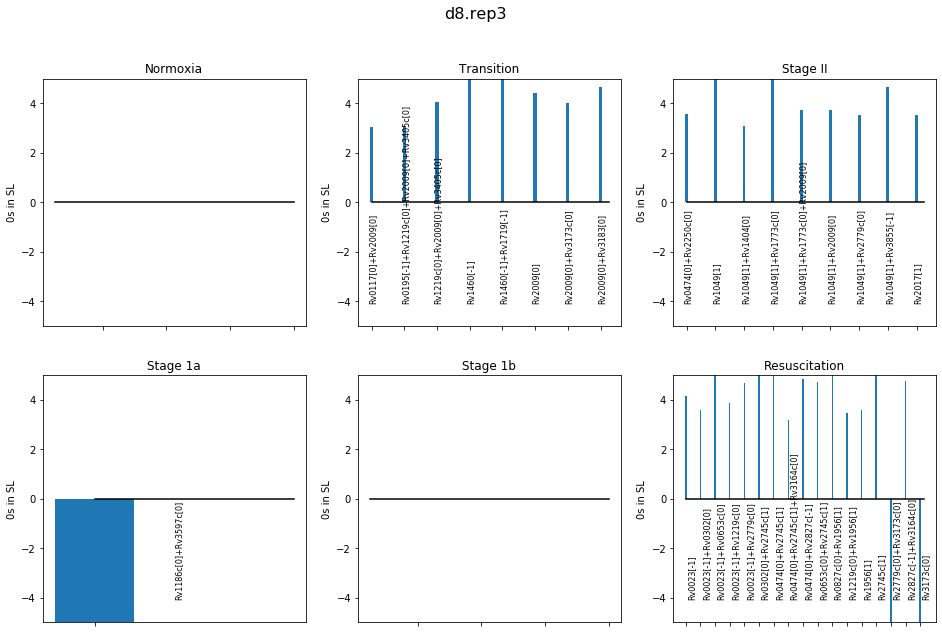

In [22]:
for instance in DF_GALAGAN.columns:
    fullProfile(DF_GALAGAN[instance], title=instance)

## Sherman

In [23]:
DF_SHERMAN.head(2)

0
Rv0576   0
Rv0691c  0

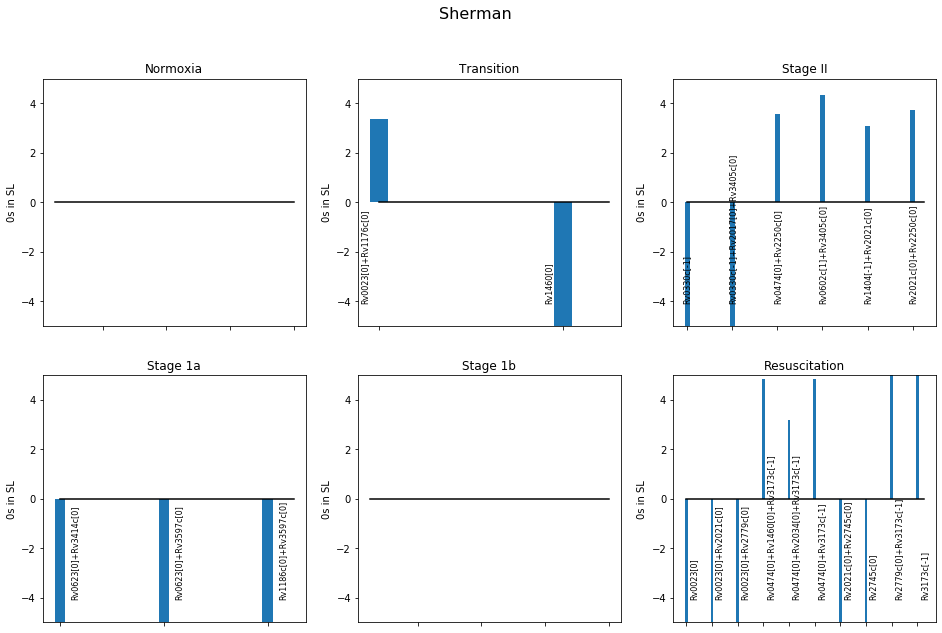

In [24]:
fullProfile(DF_SHERMAN[0], title="Sherman")

## Rustad

In [25]:
DF_RUSTAD.head(2)

H37Rv_hypoxia_4hr_rep1  H37Rv_hypoxia_4hr_rep2  \
Rv2069                       -1                      -1   
Rv1773c                      -1                      -1   

         H37Rv_hypoxia_4hr_rep4  H37Rv_hypoxia_4hr_rep5  \
Rv2069                        1                       1   
Rv1773c                      -1                       1   

         H37Rv_hypoxia_4hr_rep6  H37Rv_hypoxia_8hr_rep1  \
Rv2069                       -1                      -1   
Rv1773c                      -1                      -1   

         H37Rv_hypoxia_8hr_rep2  H37Rv_hypoxia_12hr_rep1  \
Rv2069                        1                       -1   
Rv1773c                      -1                       -1   

         H37Rv_hypoxia_12hr_rep2  H37Rv_hypoxia_1day_rep2  ...  \
Rv2069                         1                       -1  ...   
Rv1773c                        1                        1  ...   

         H37Rv_hypoxia_4hr_rep6.1  H37Rv_hypoxia_8hr_rep3  \
Rv2069                          1                       1   
Rv1773c                         1                       1   

         H37Rv_hypoxia_12hr_rep3  H37Rv_hypoxia_1day_rep4  \
Rv2069                         1                       -1   
Rv1773c                        1                       -1   

         H37Rv_hypoxia_1day_rep10  H37Rv_hypoxia_4day_rep1  \
Rv2069                          1                        1   
Rv1773c                         1                       -1   

         H37Rv_hypoxia_4day_rep3  H37Rv_hypoxia_7day_rep4  \
Rv2069                         1                       -1   
Rv1773c                       -1                        1   

         H37Rv_hypoxia_7day_rep2  H37Rv_hypoxia_7day_rep3  
Rv2069                         1                       -1  
Rv1773c                       -1                        1  

[2 rows x 52 columns]

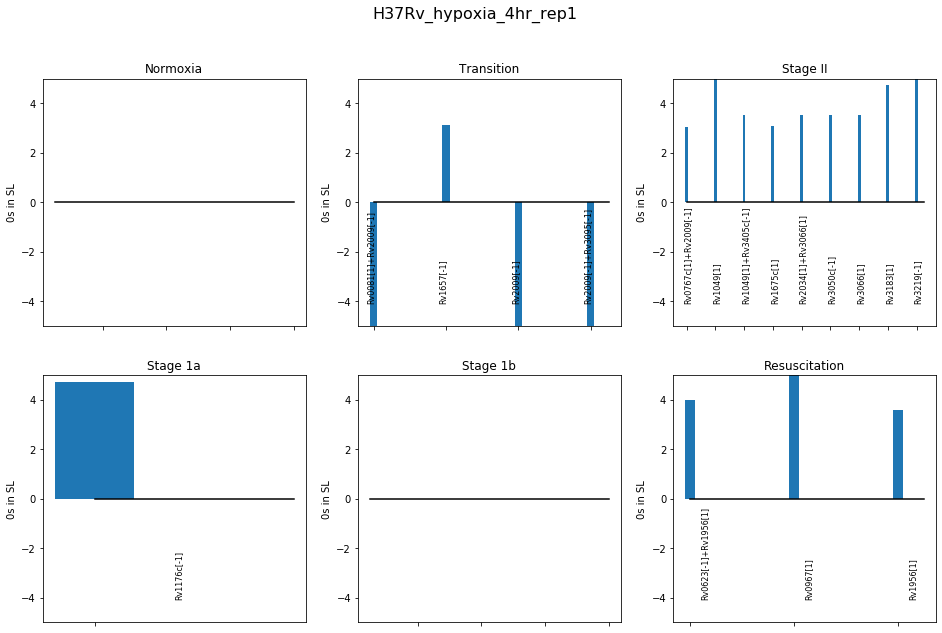

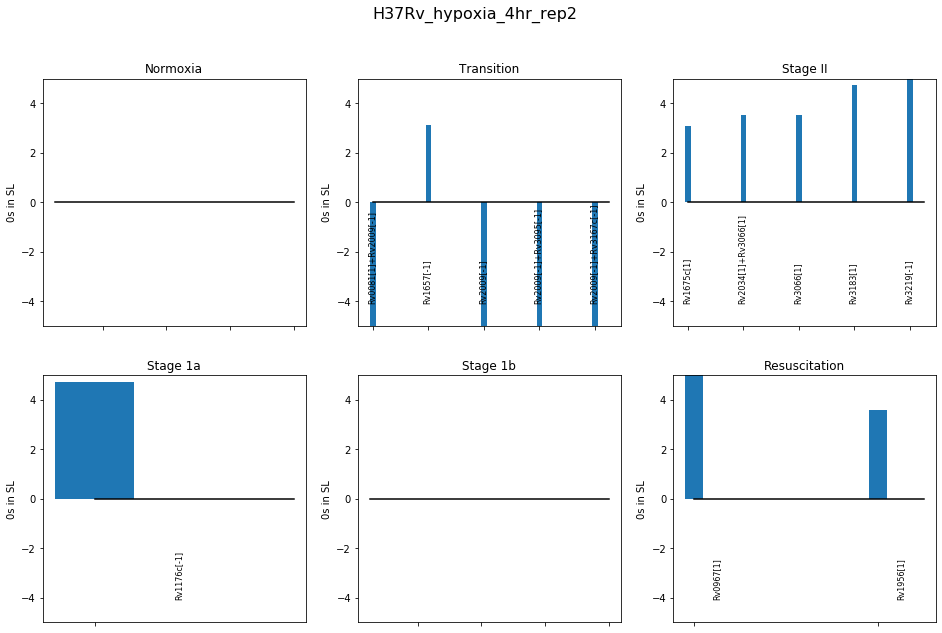

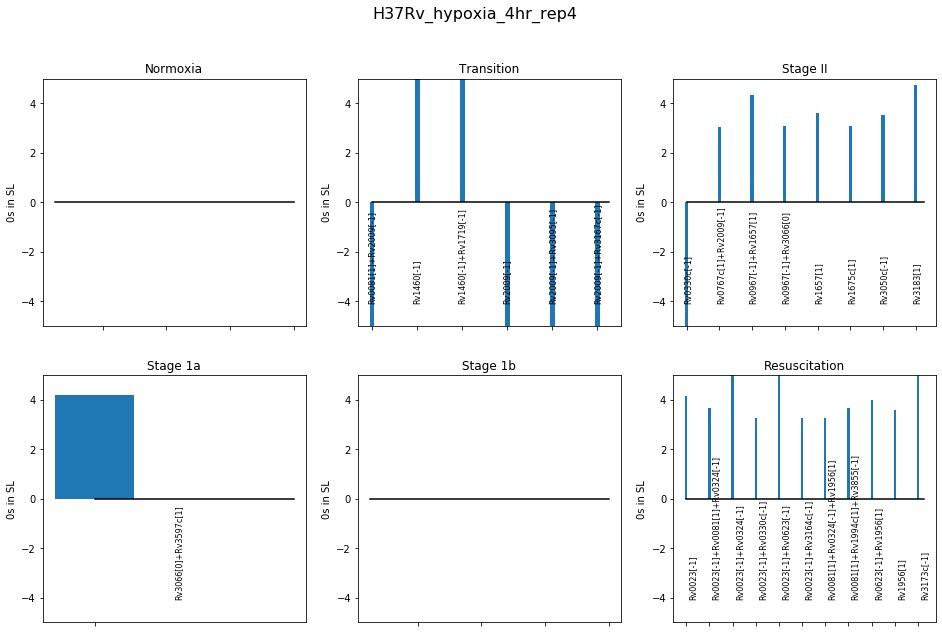

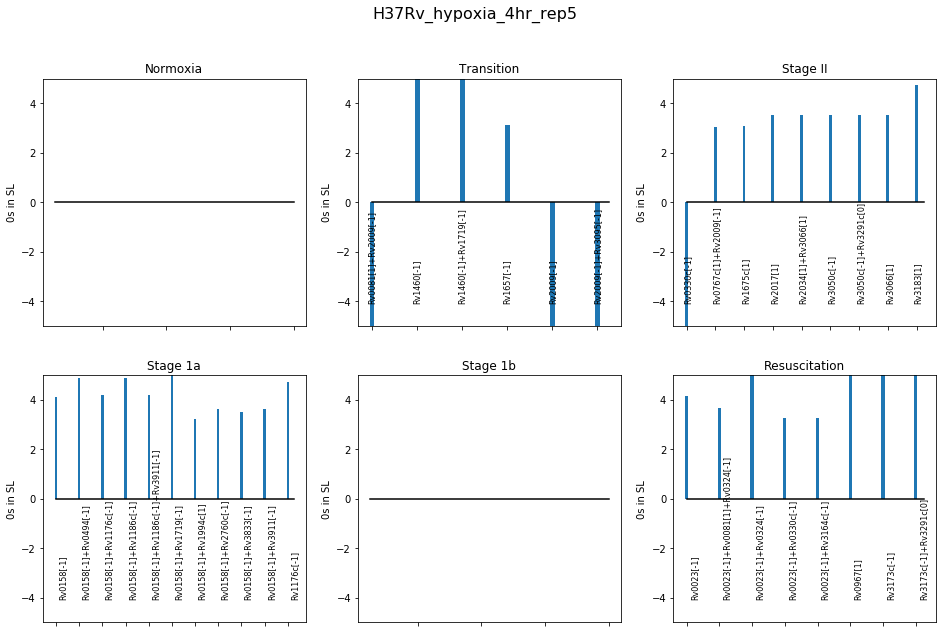

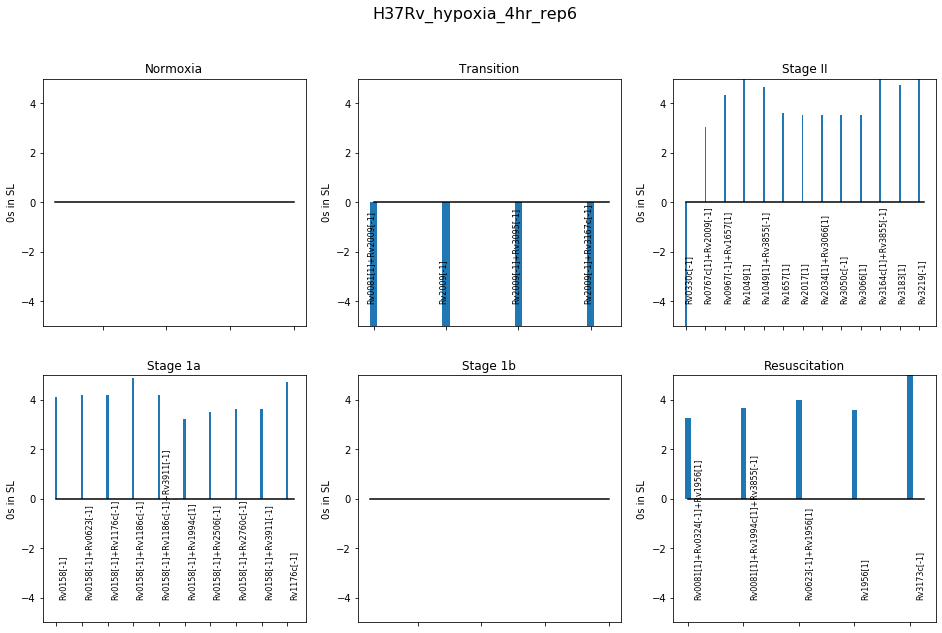

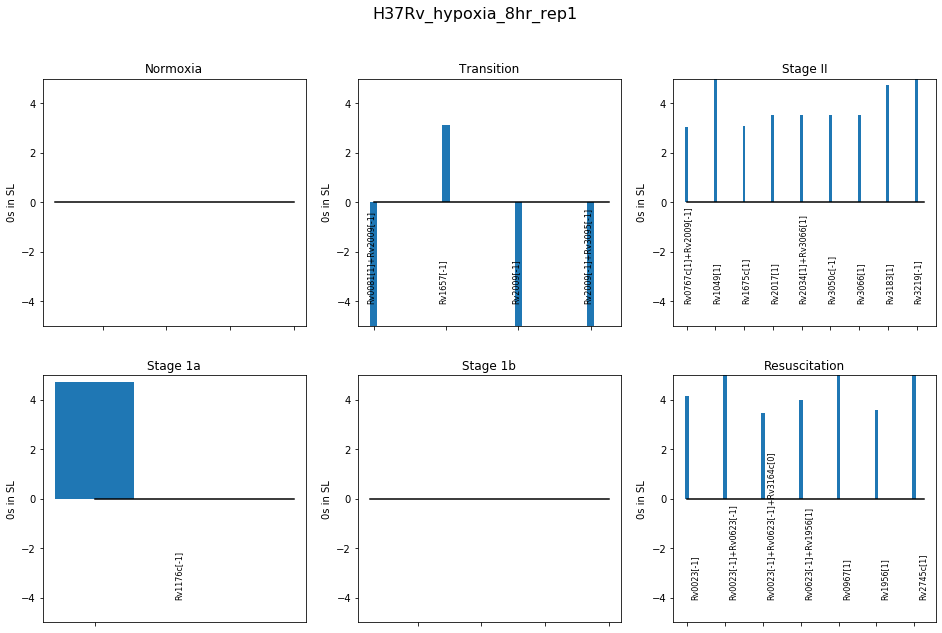

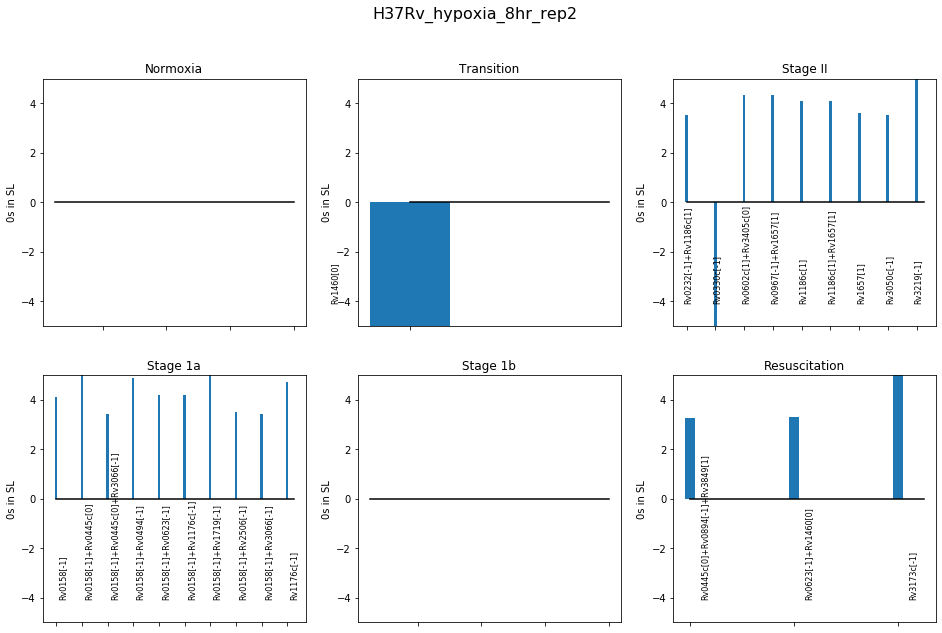

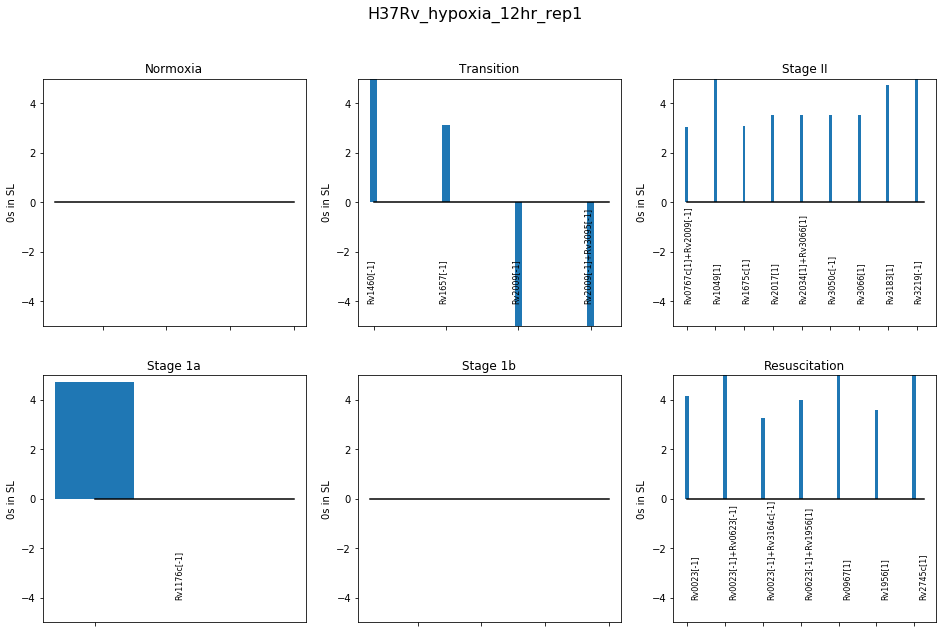

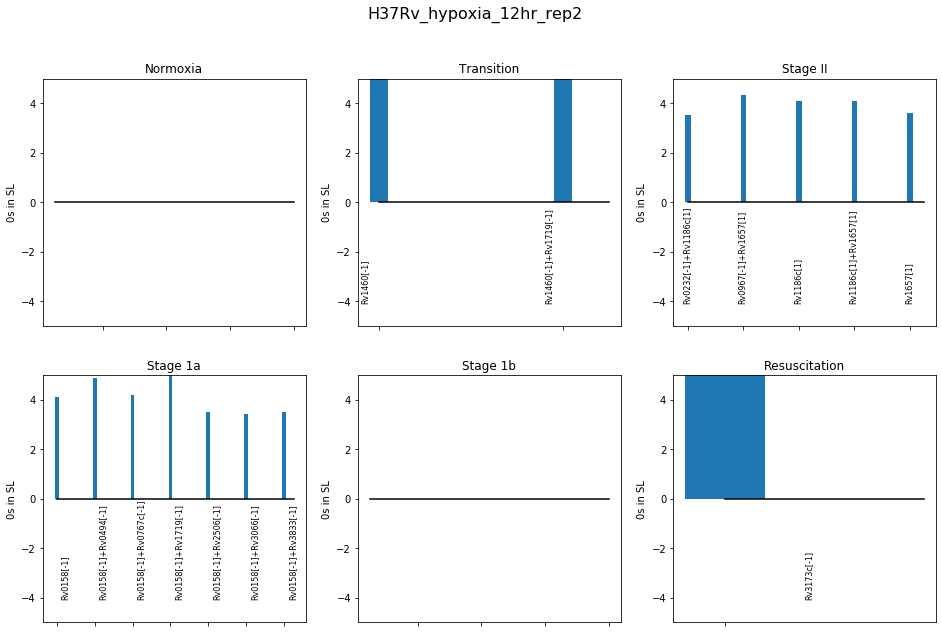

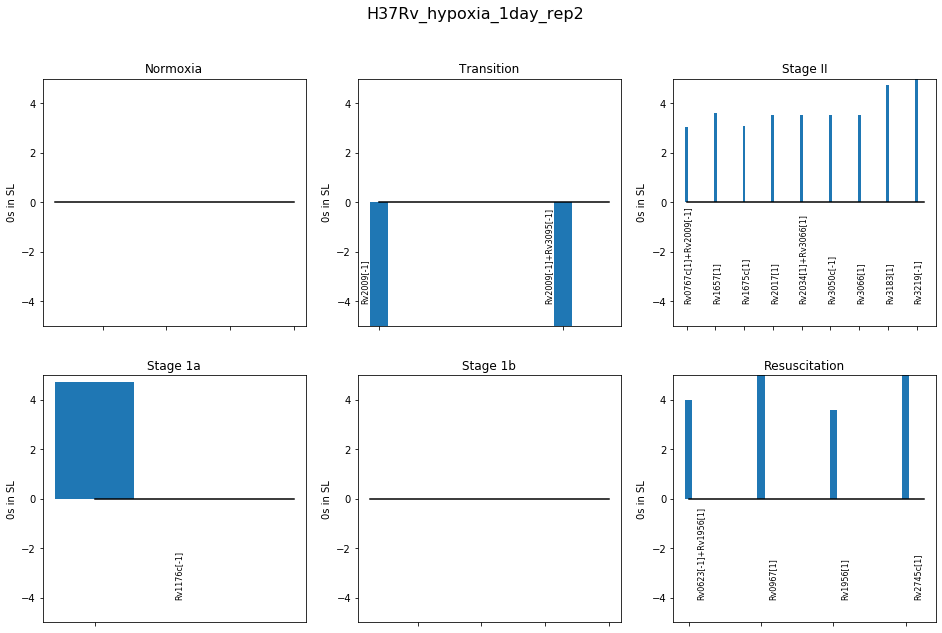

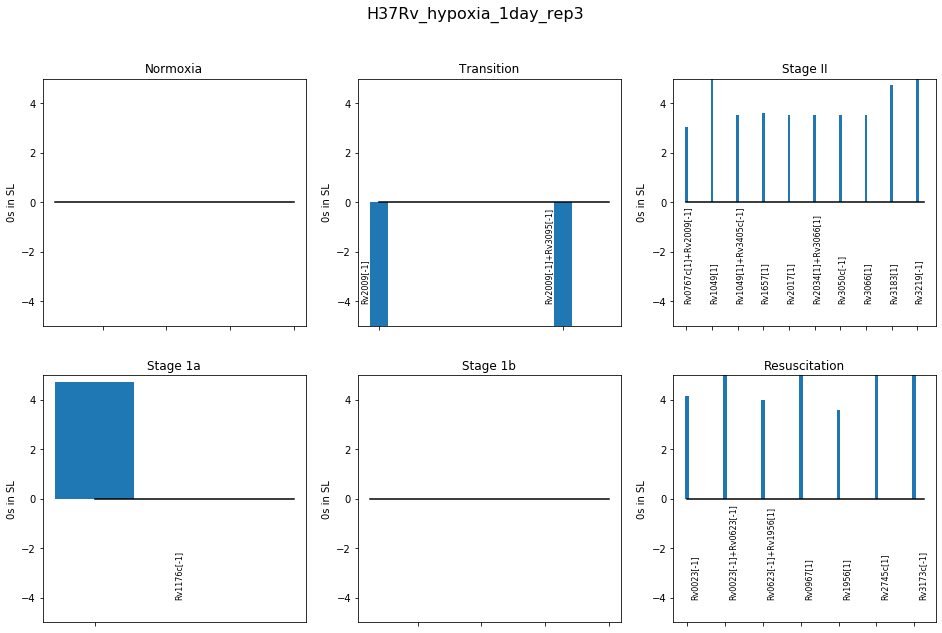

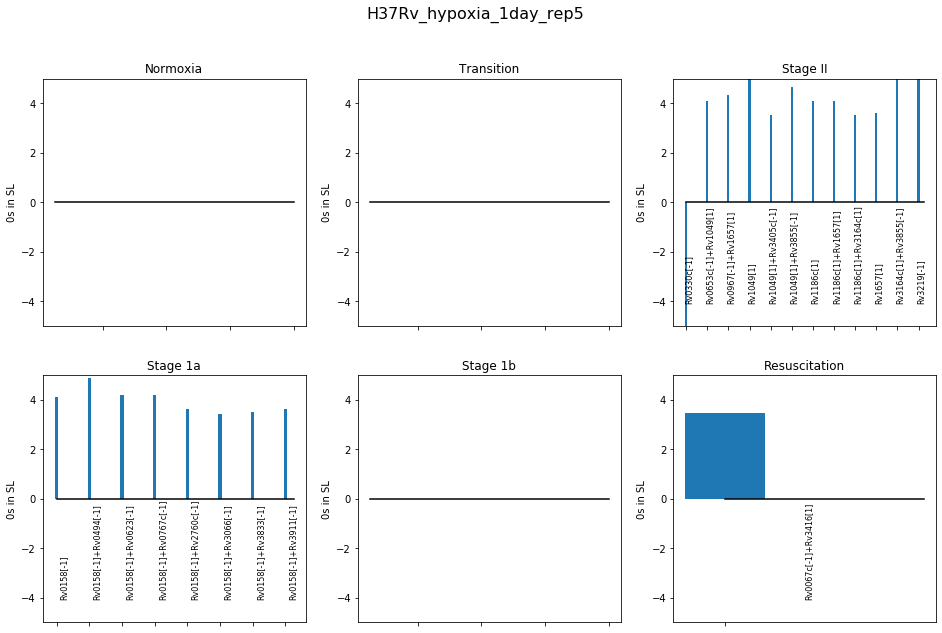

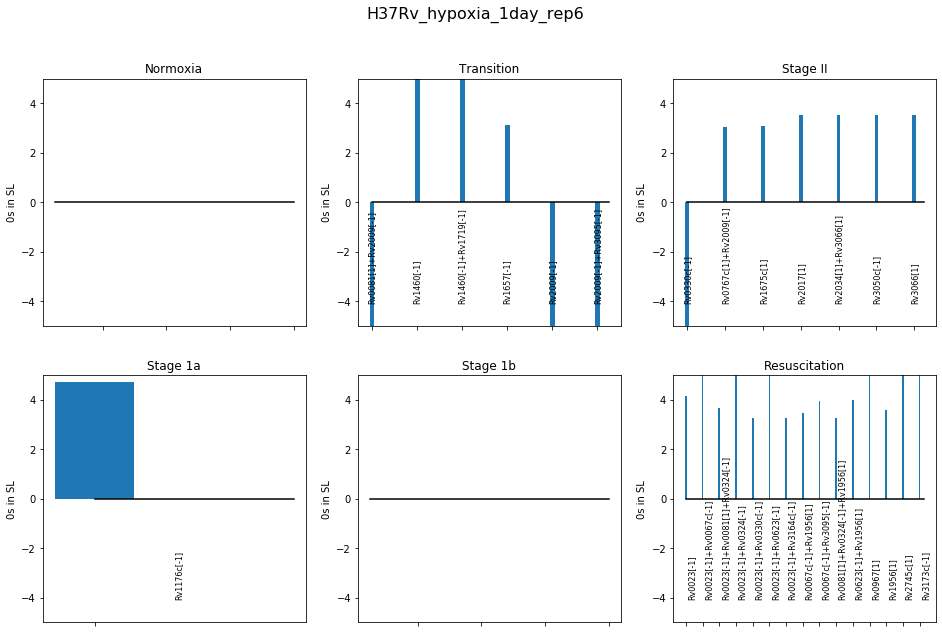

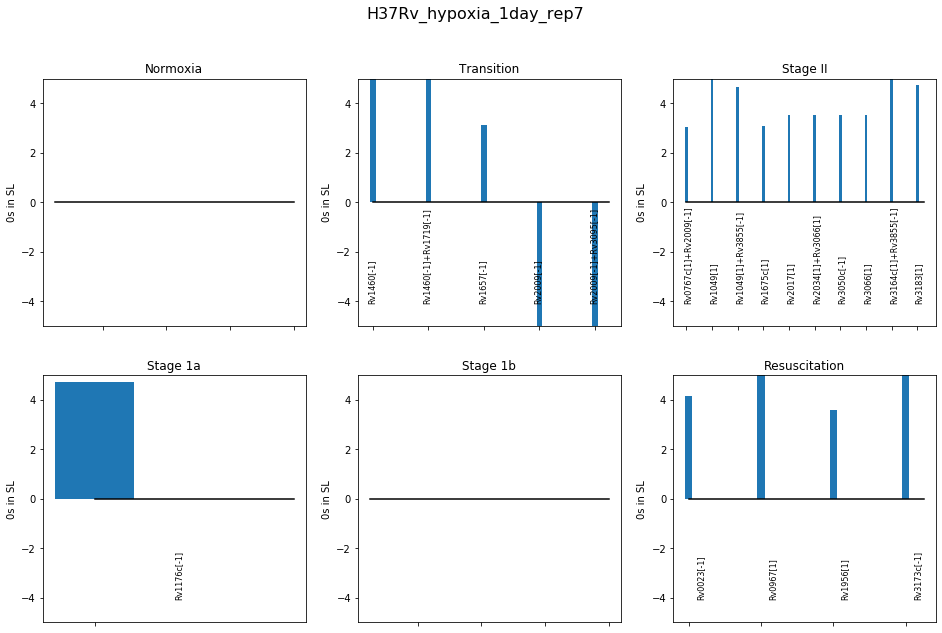

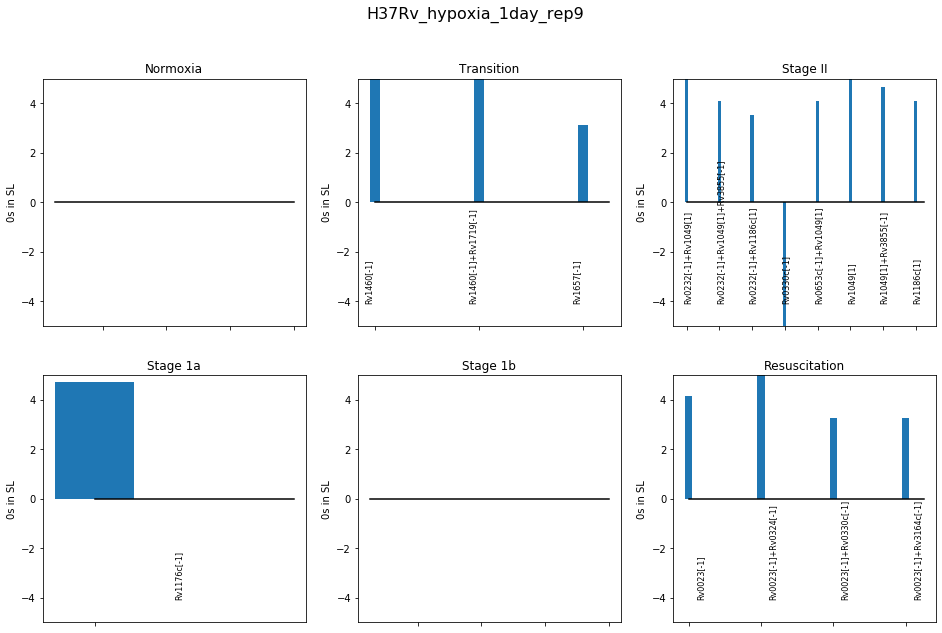

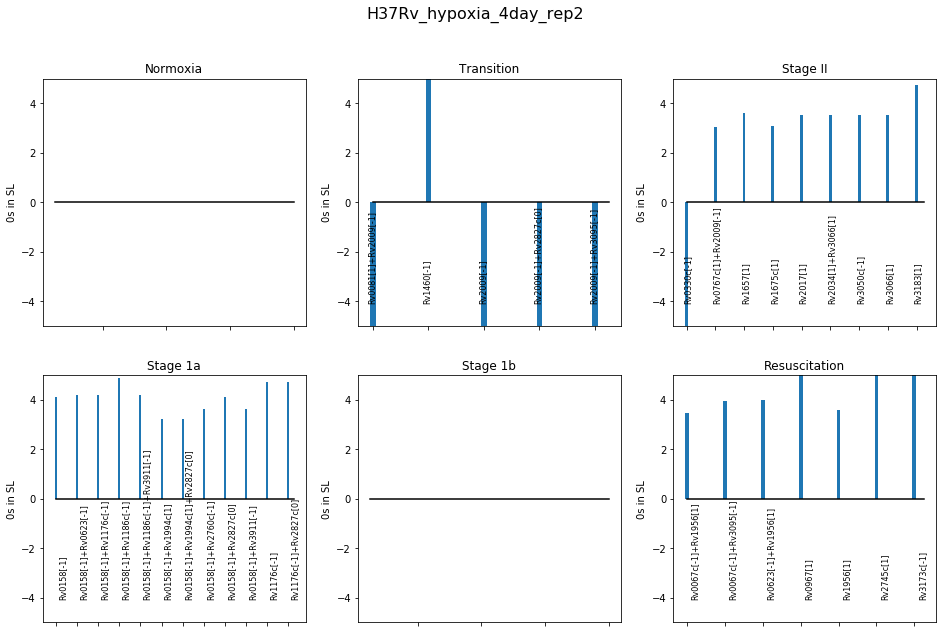

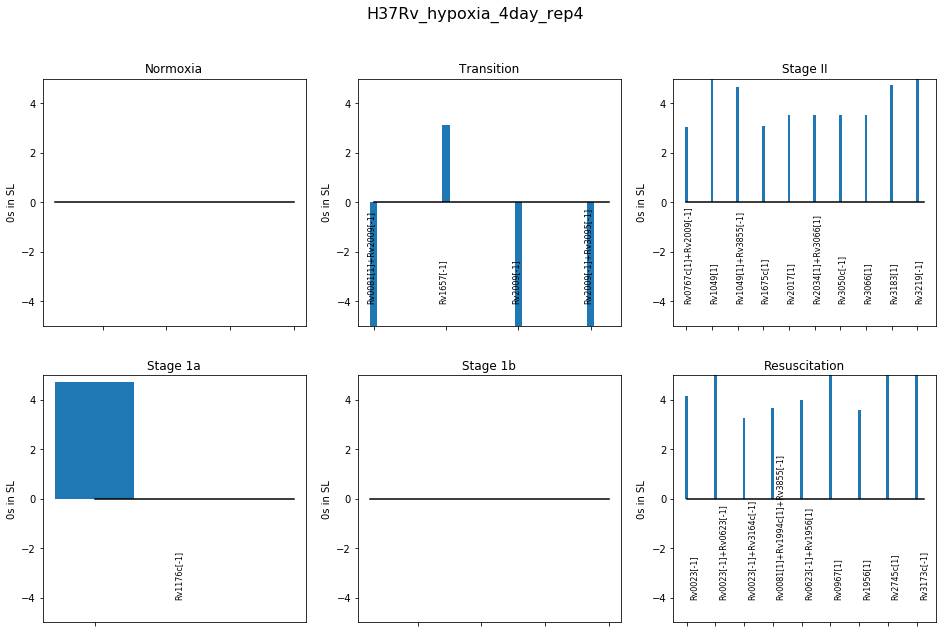

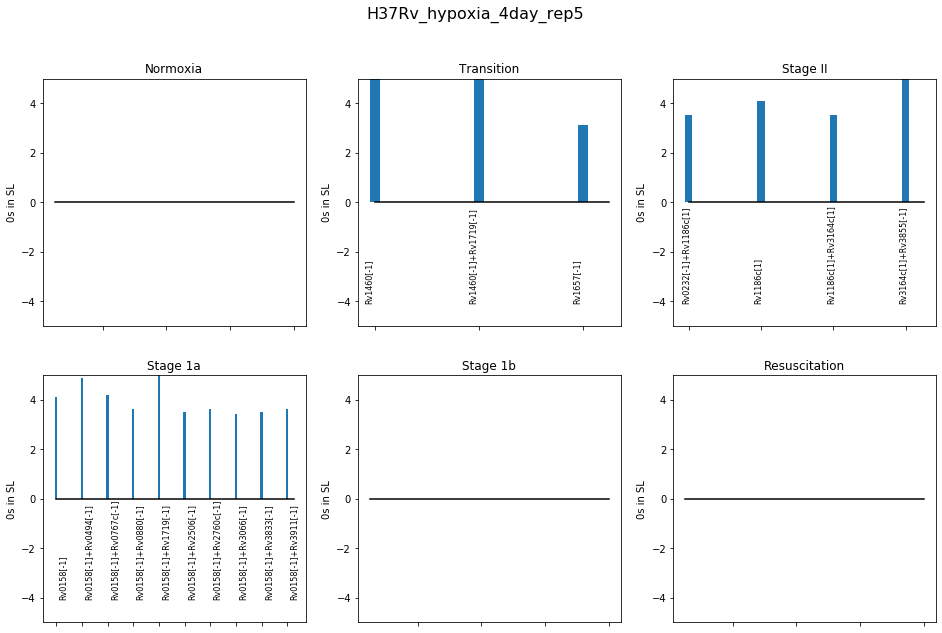

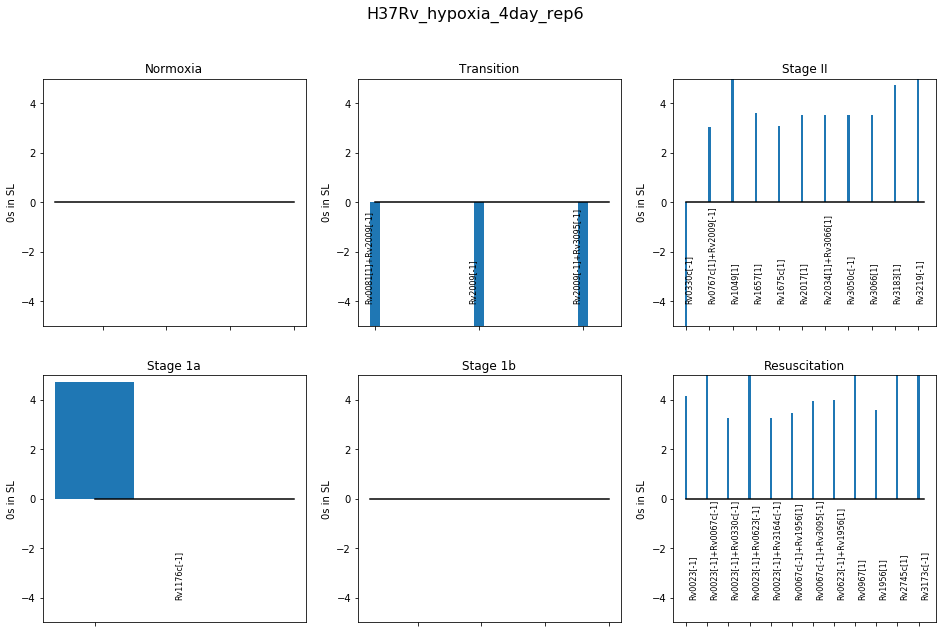

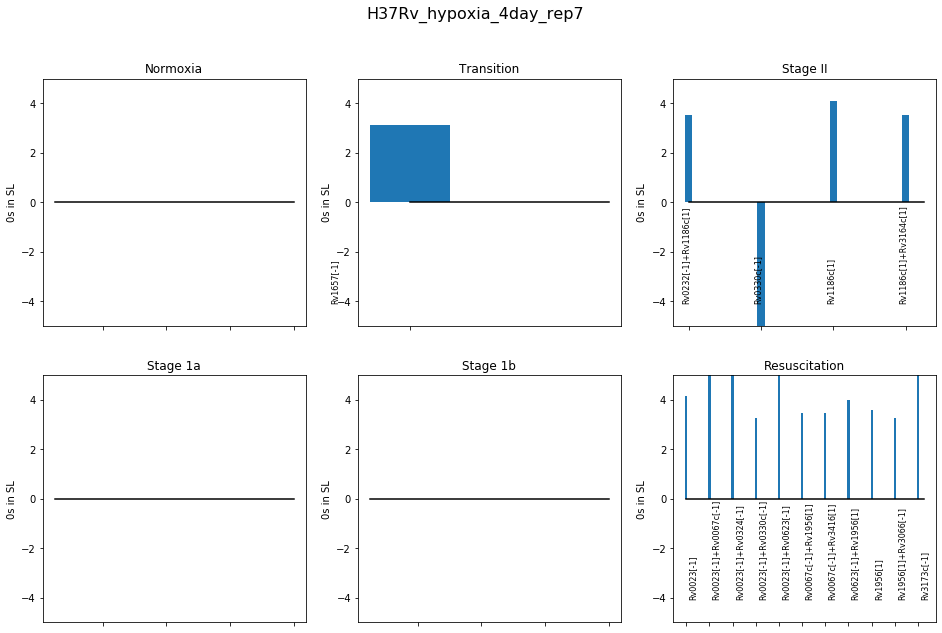

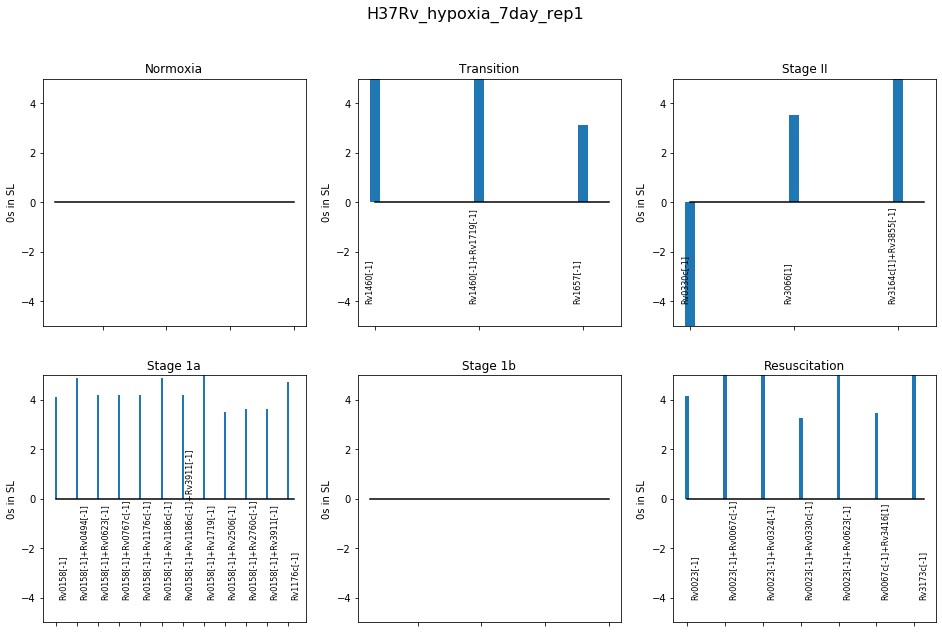

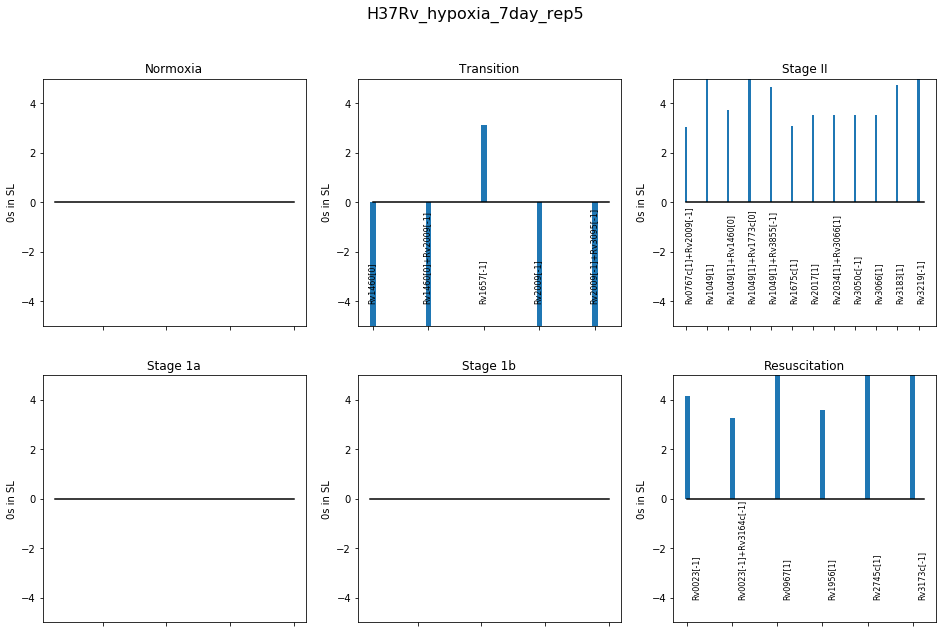

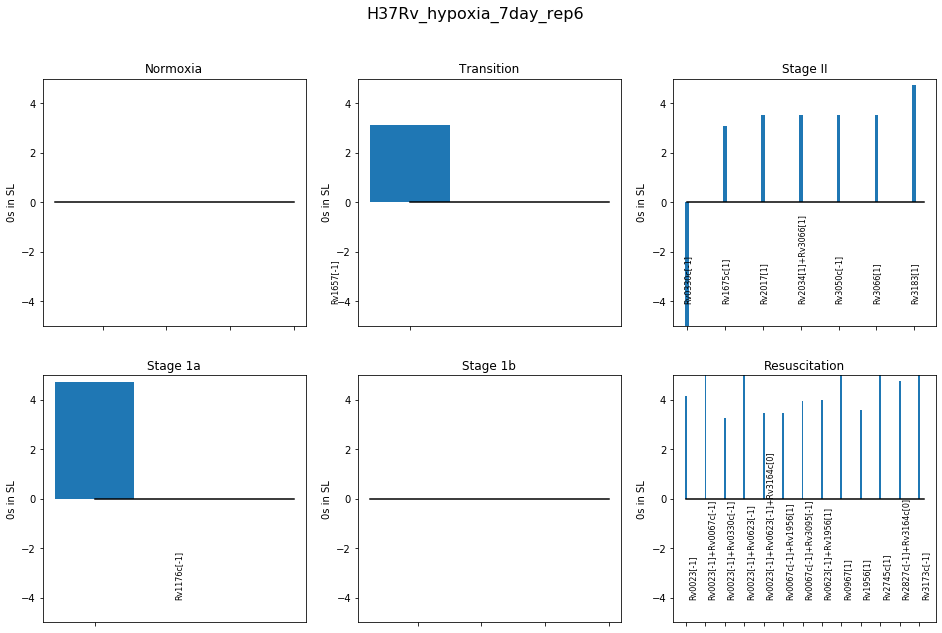

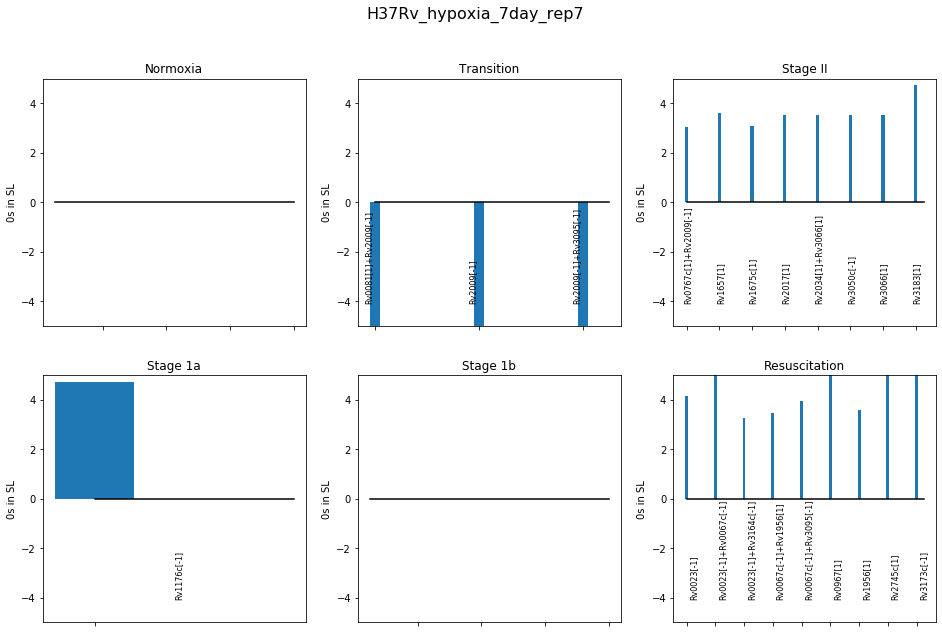

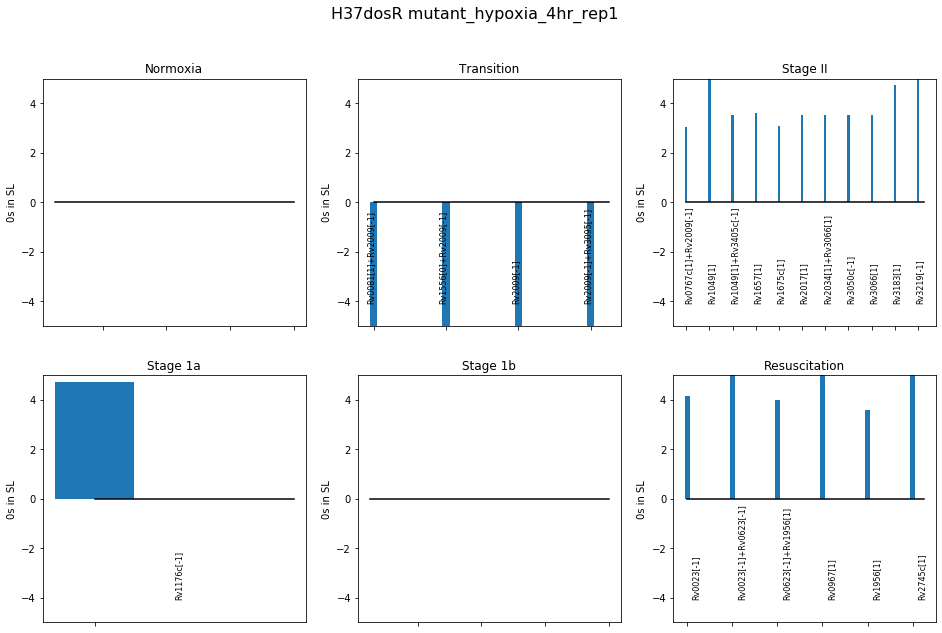

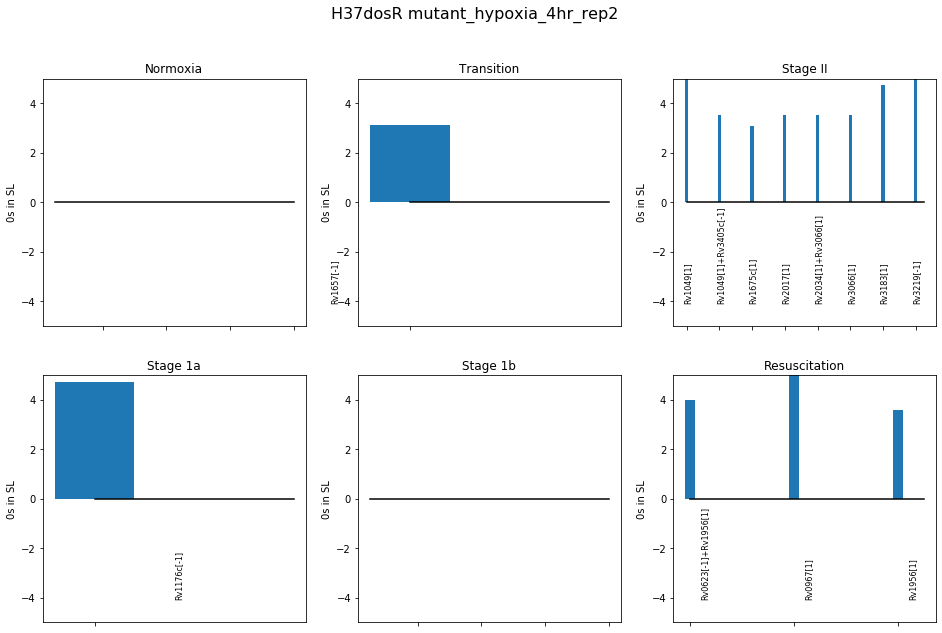

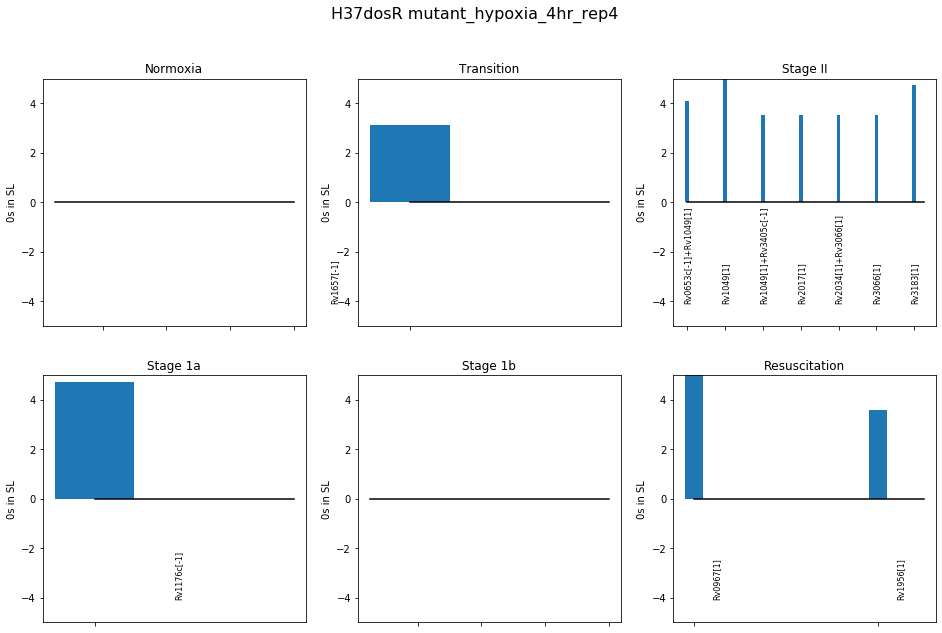

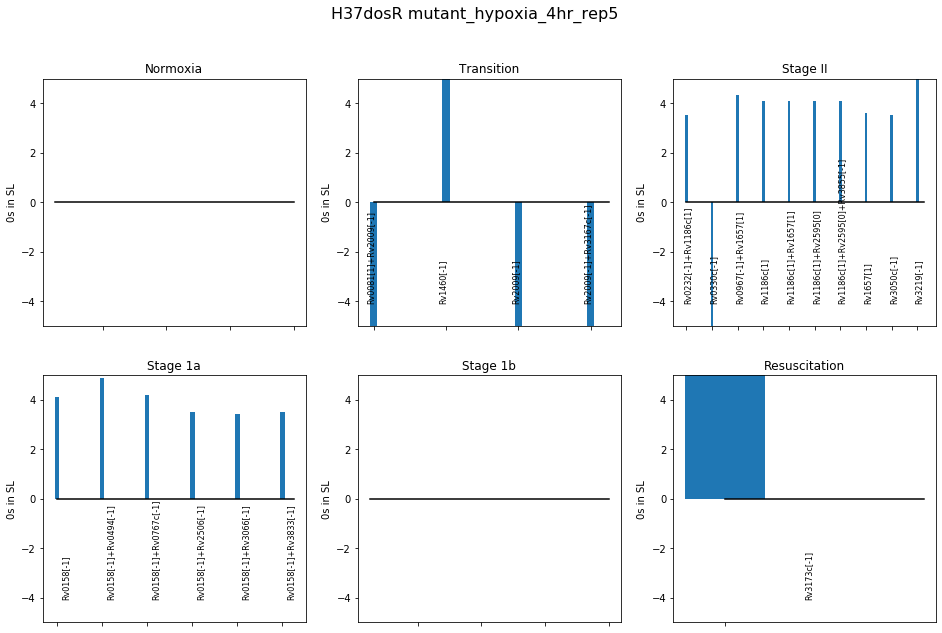

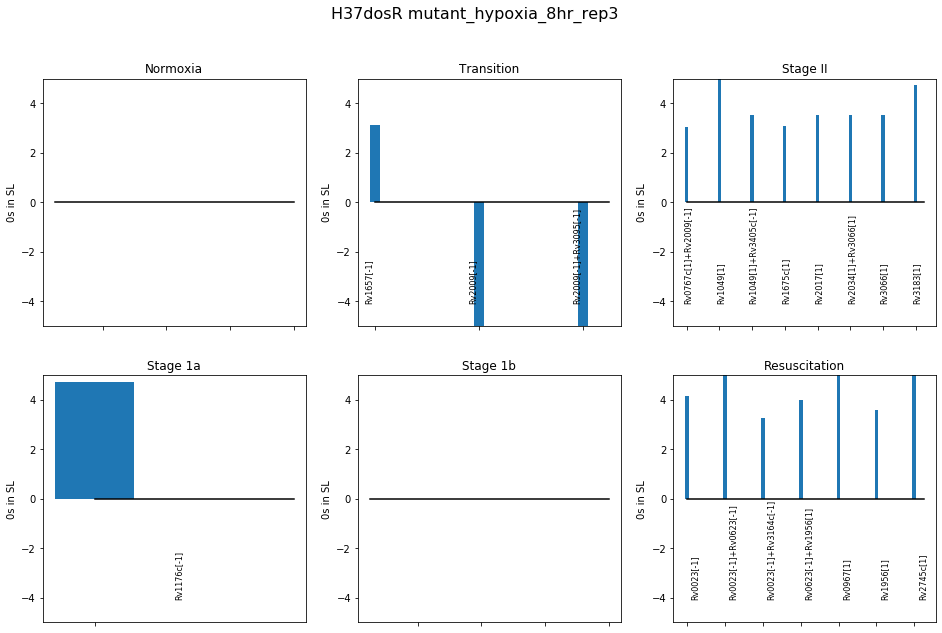

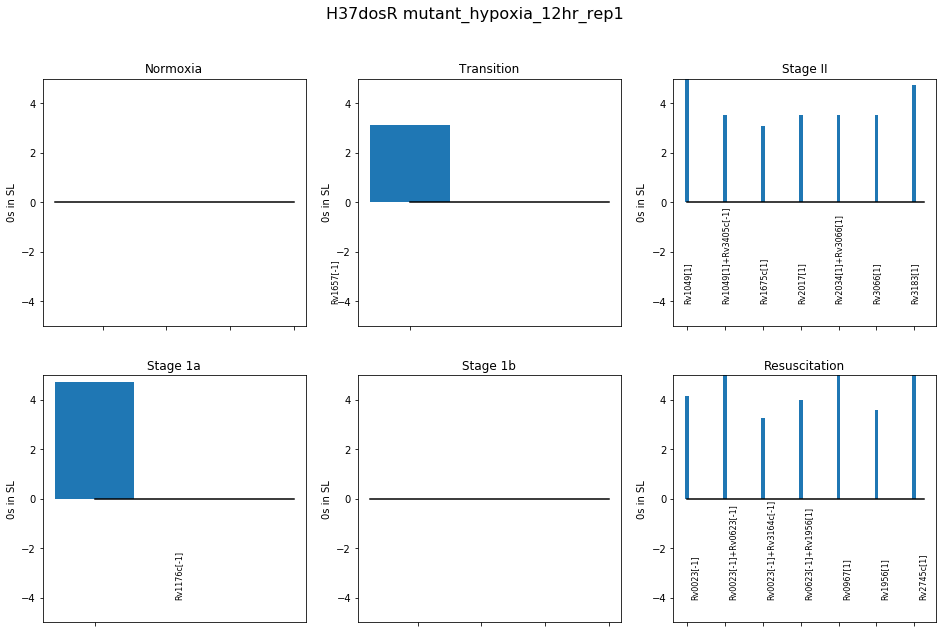

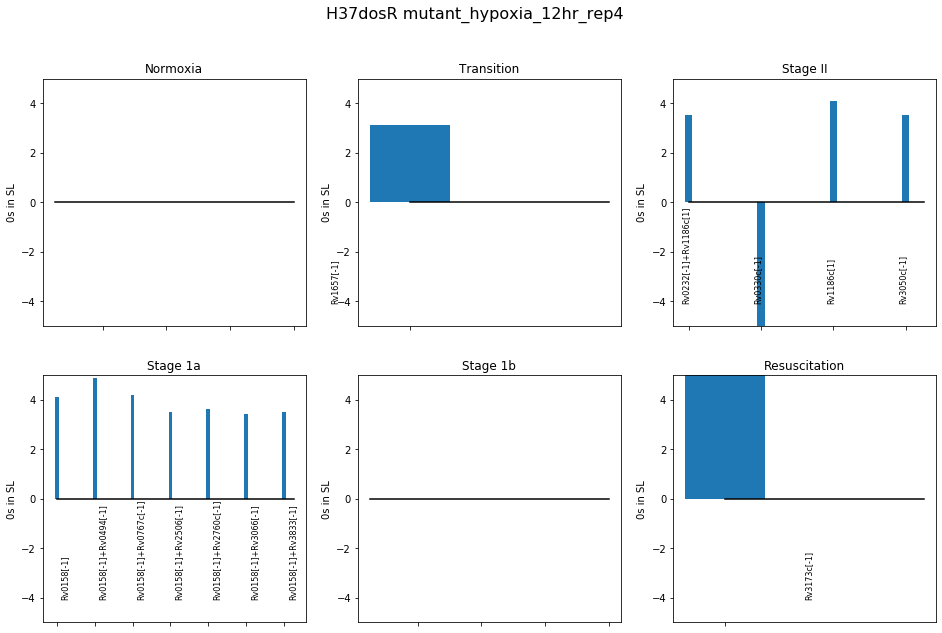

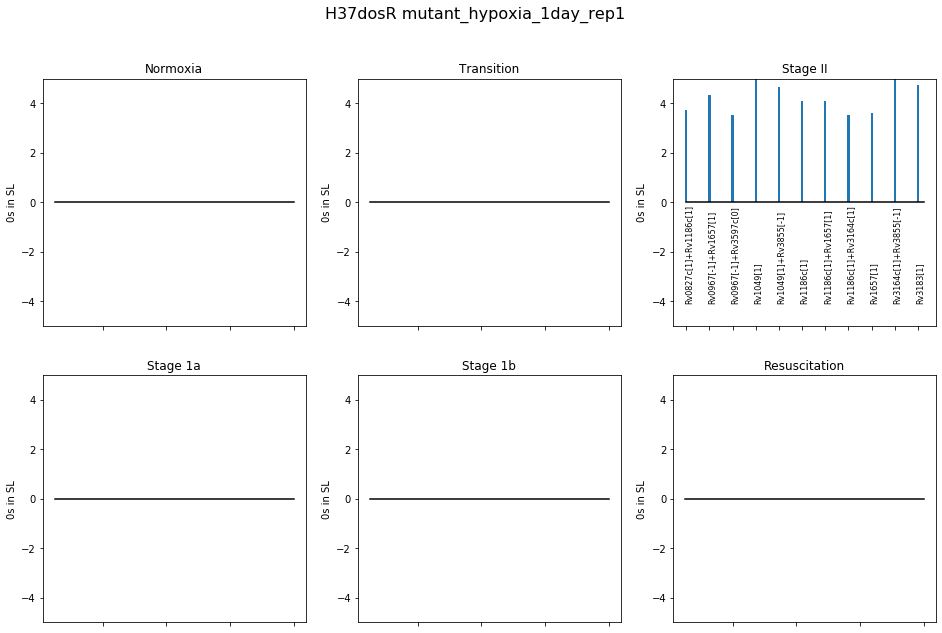

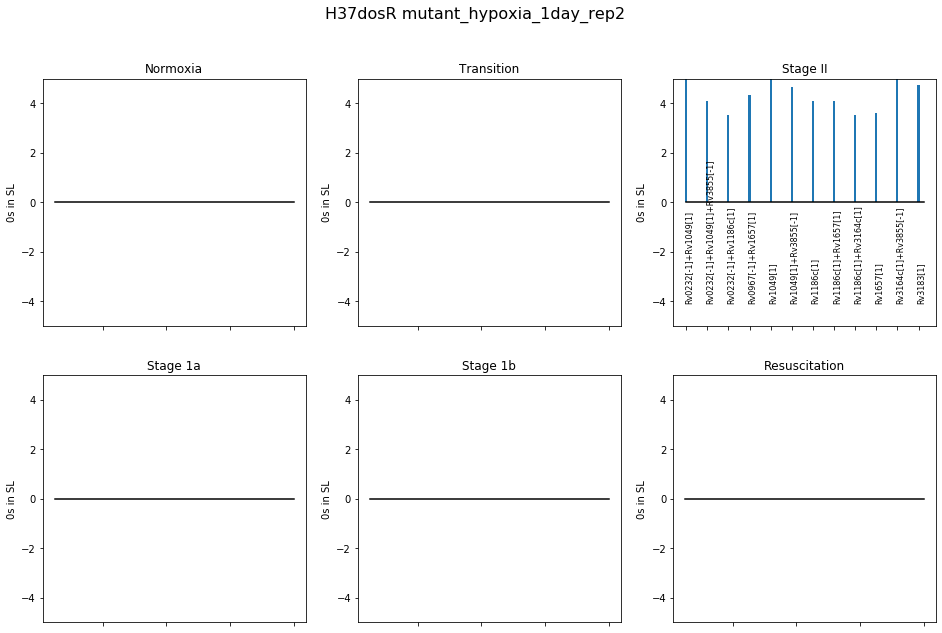

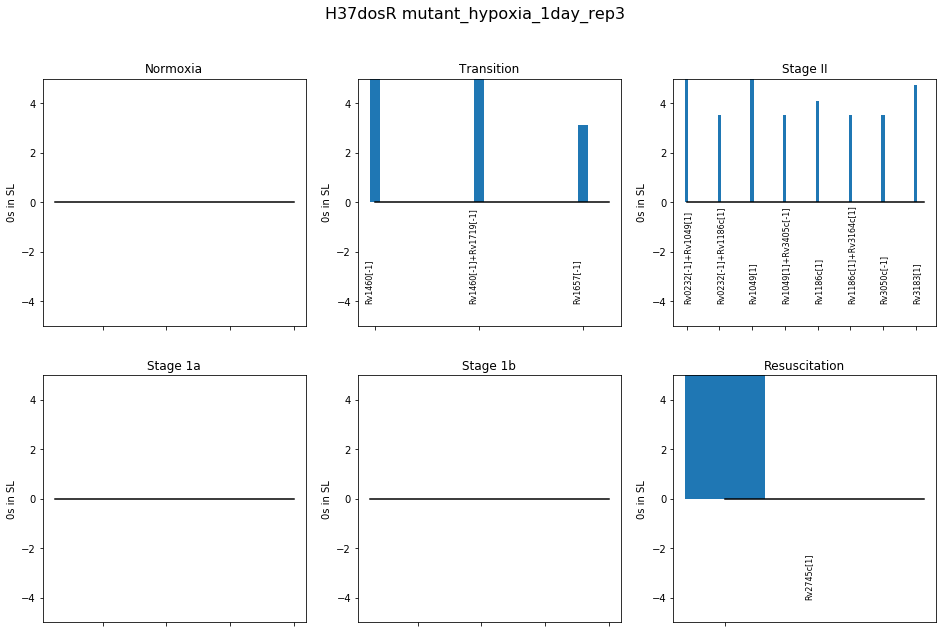

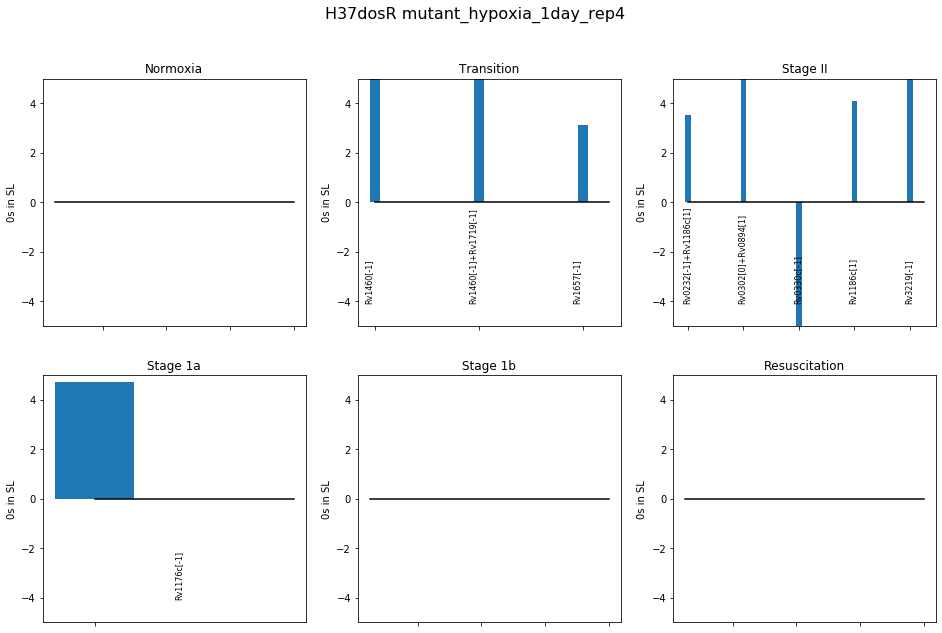

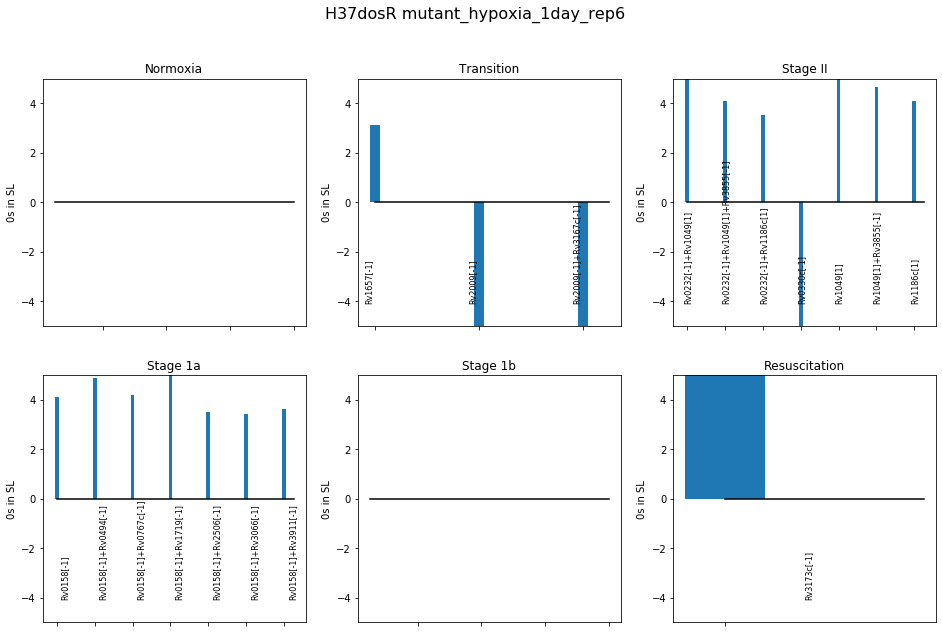

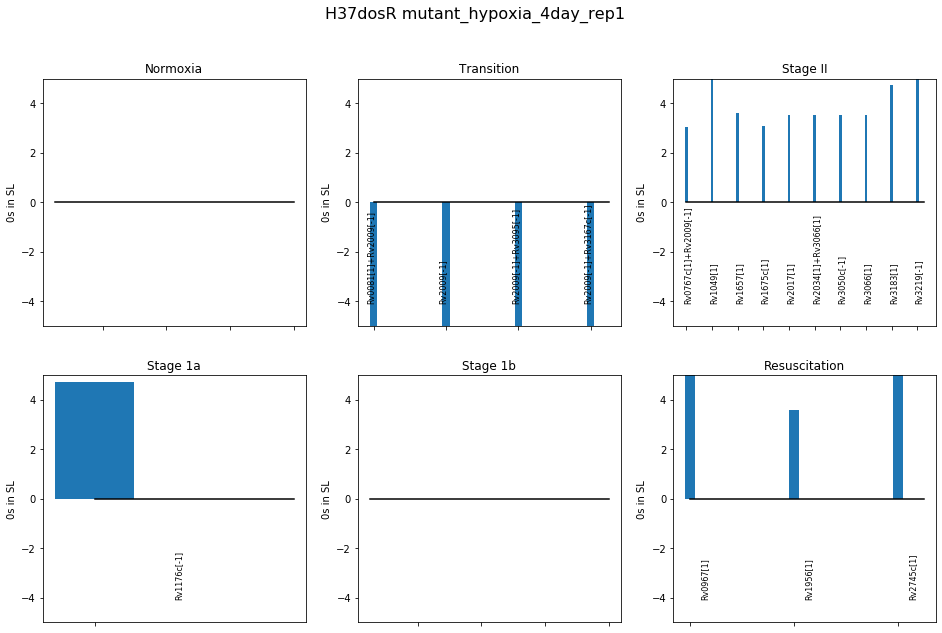

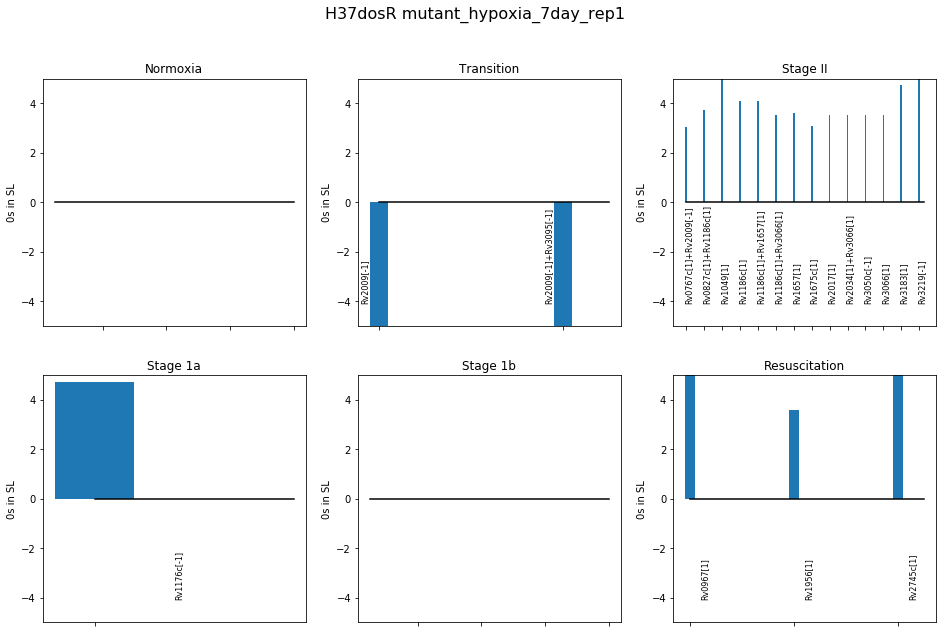

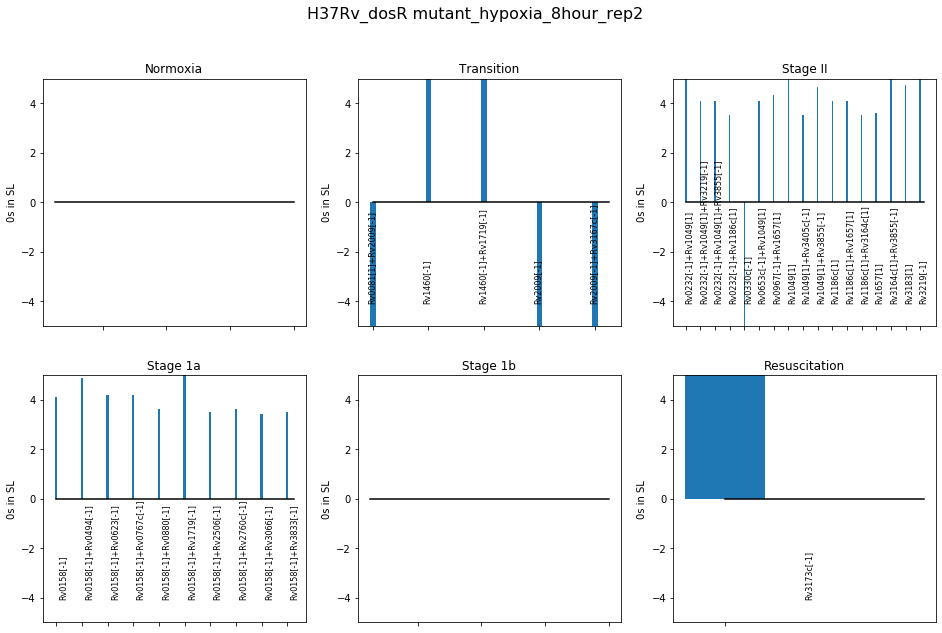

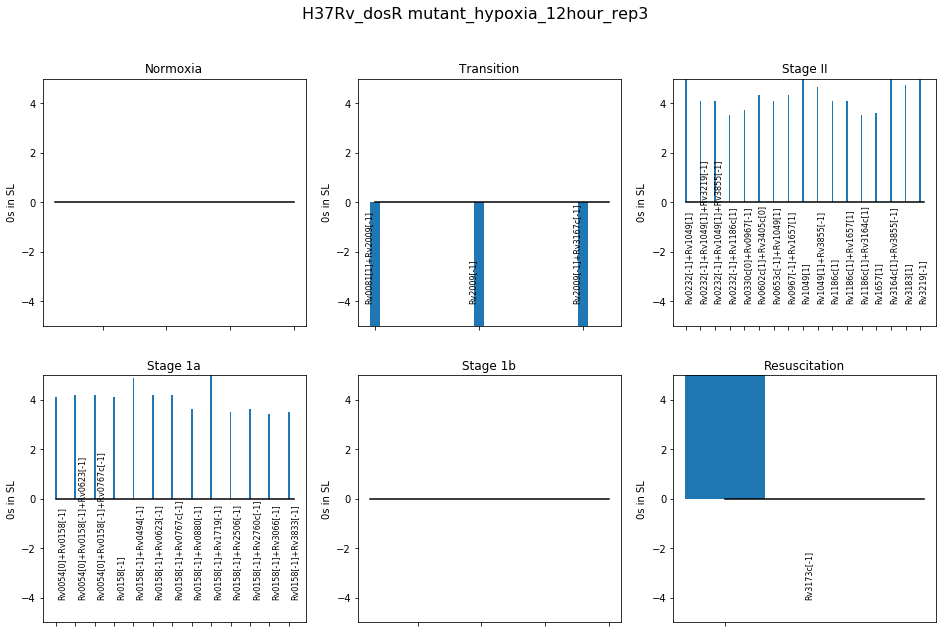

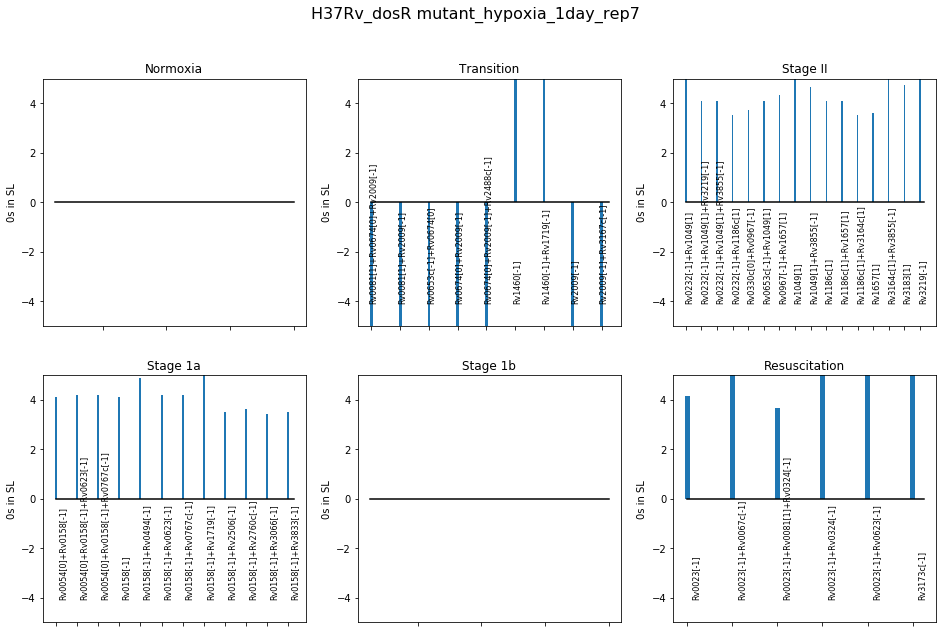

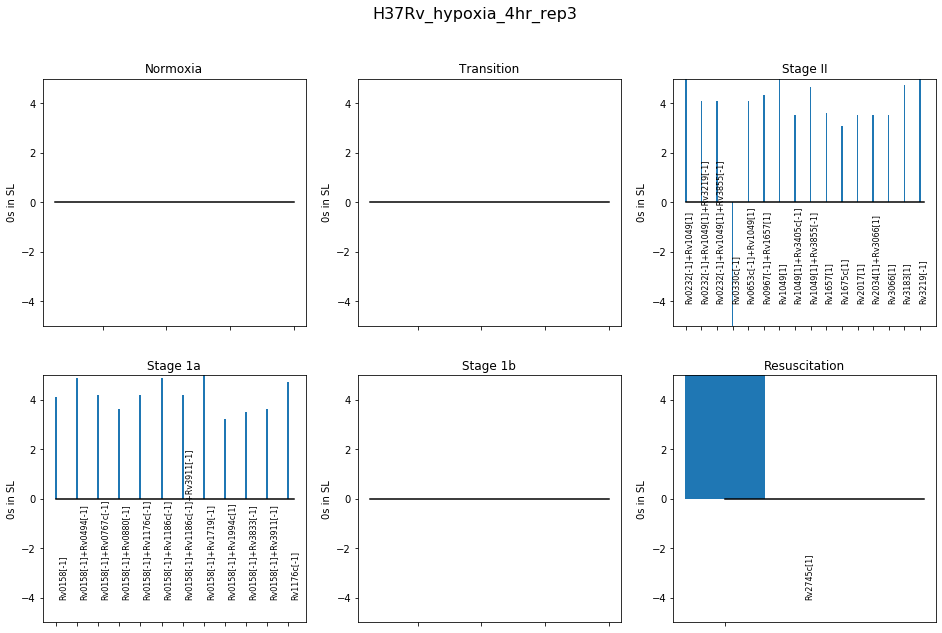

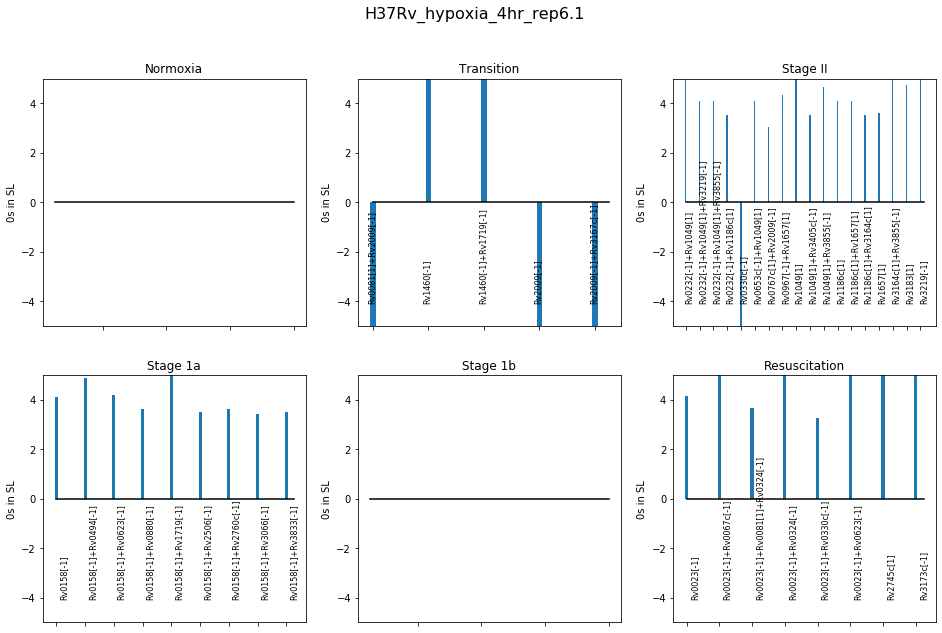

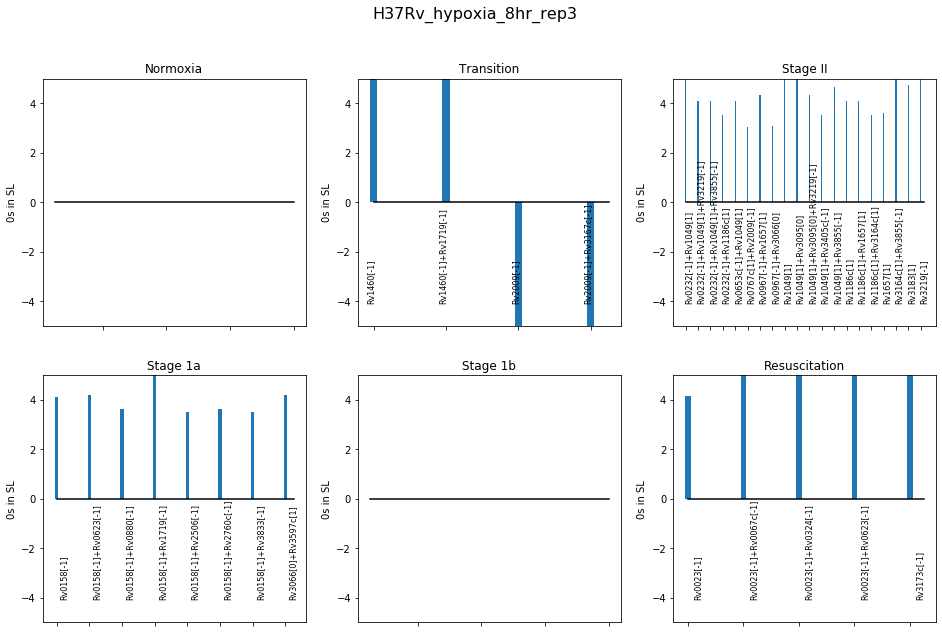

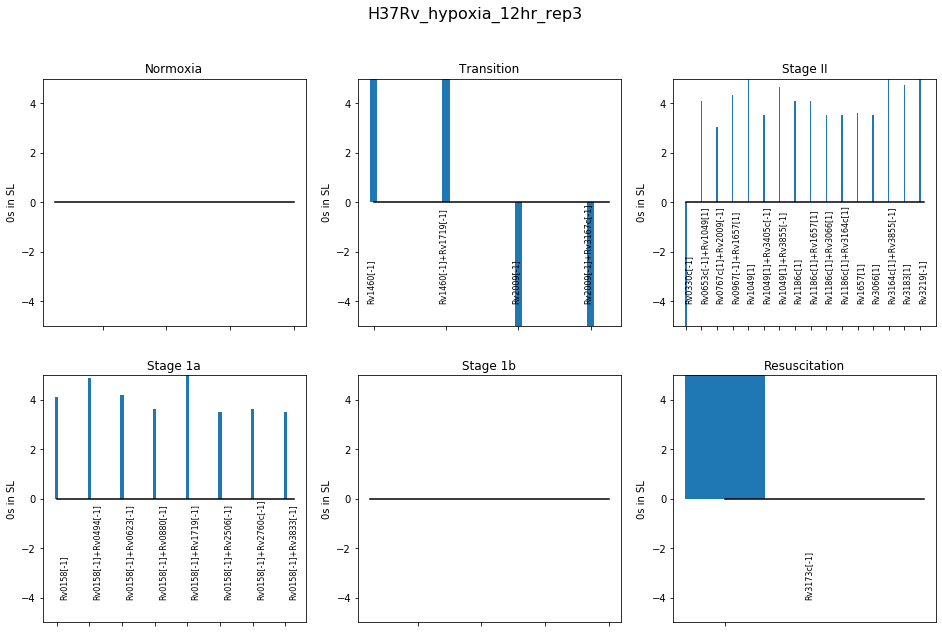

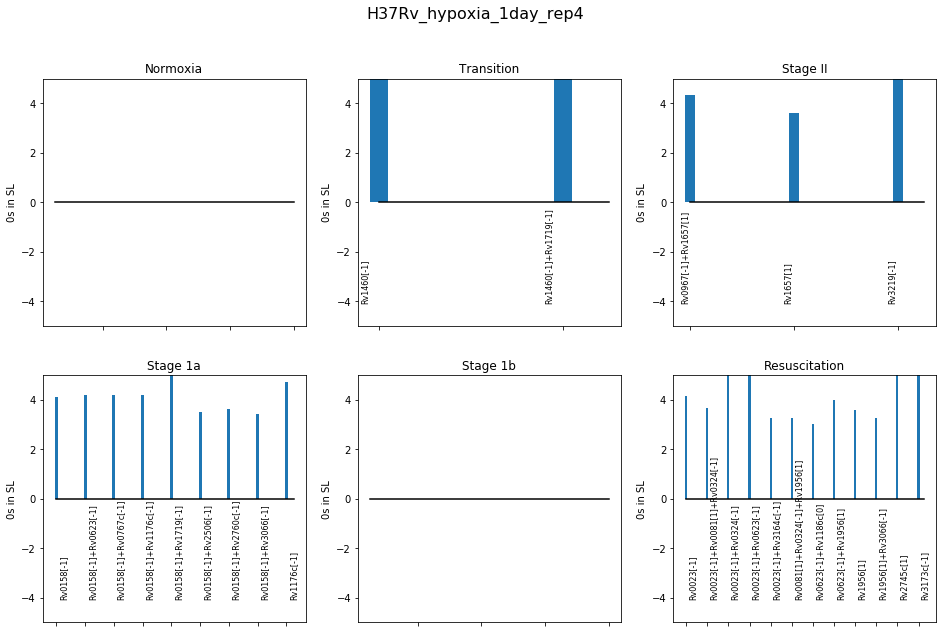

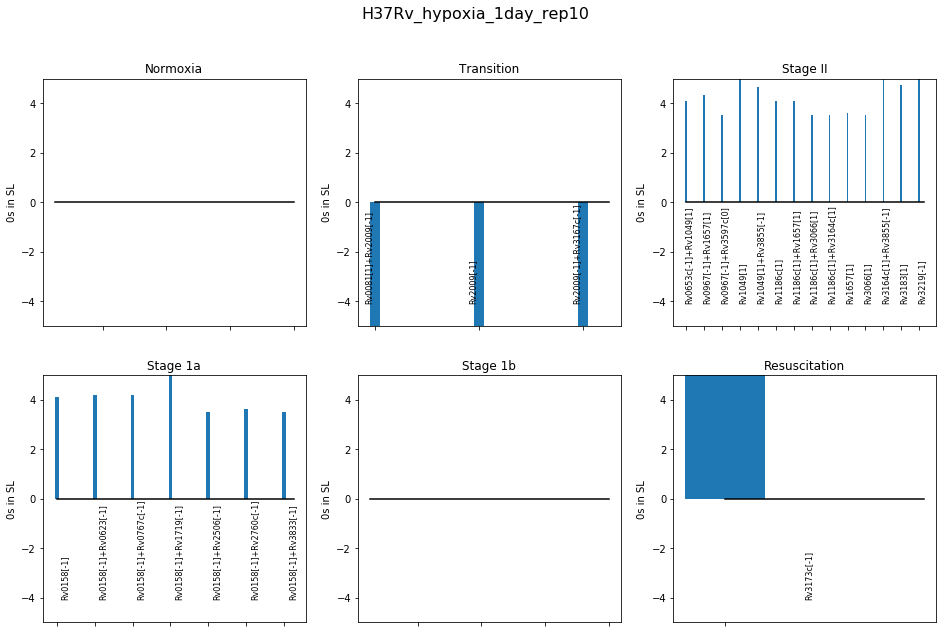

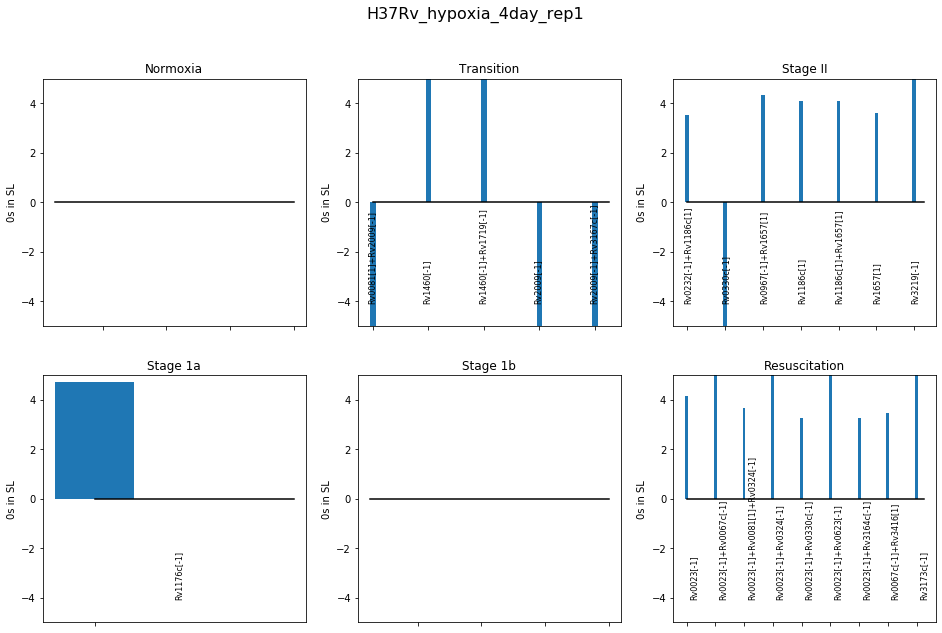

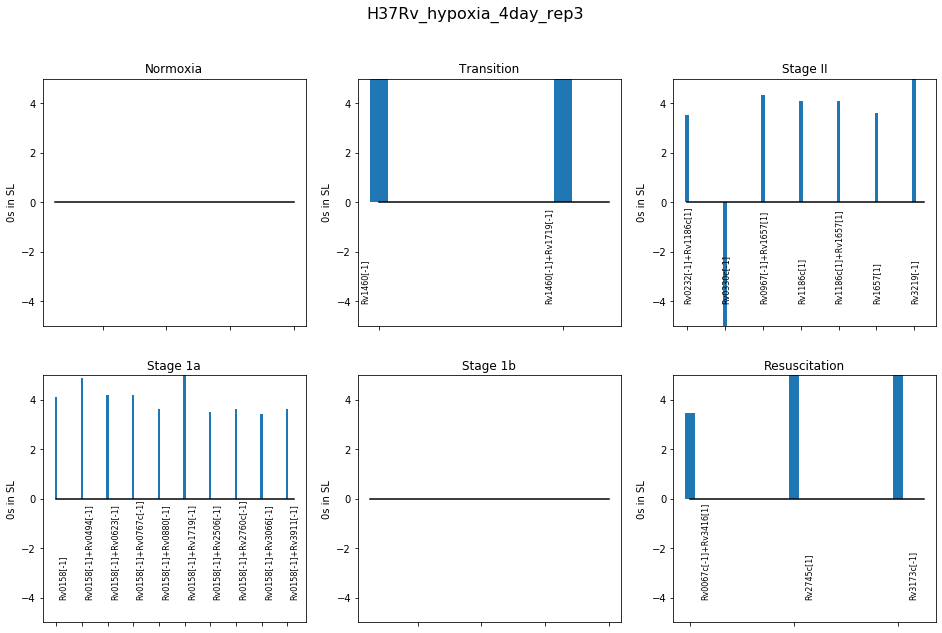

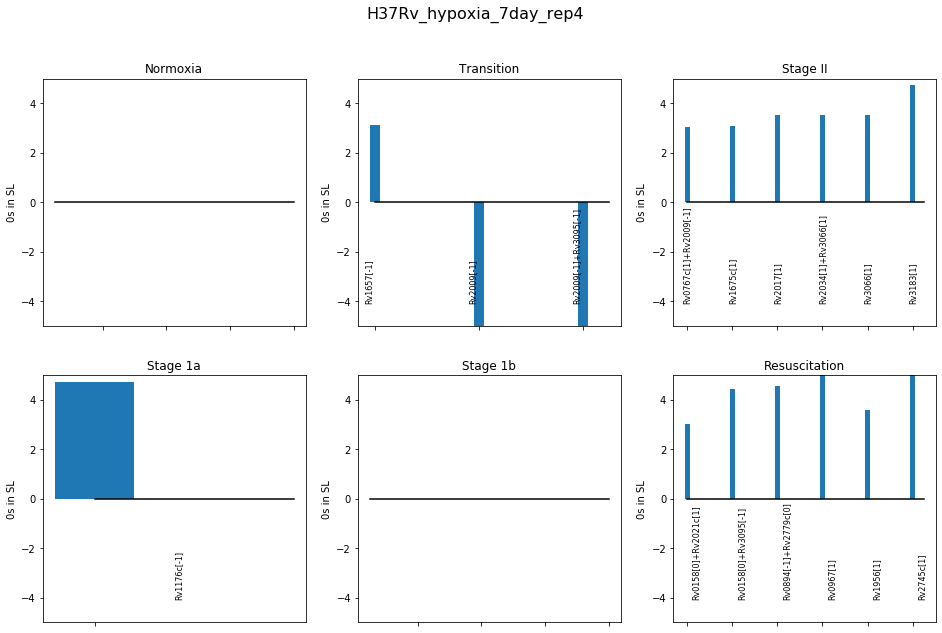

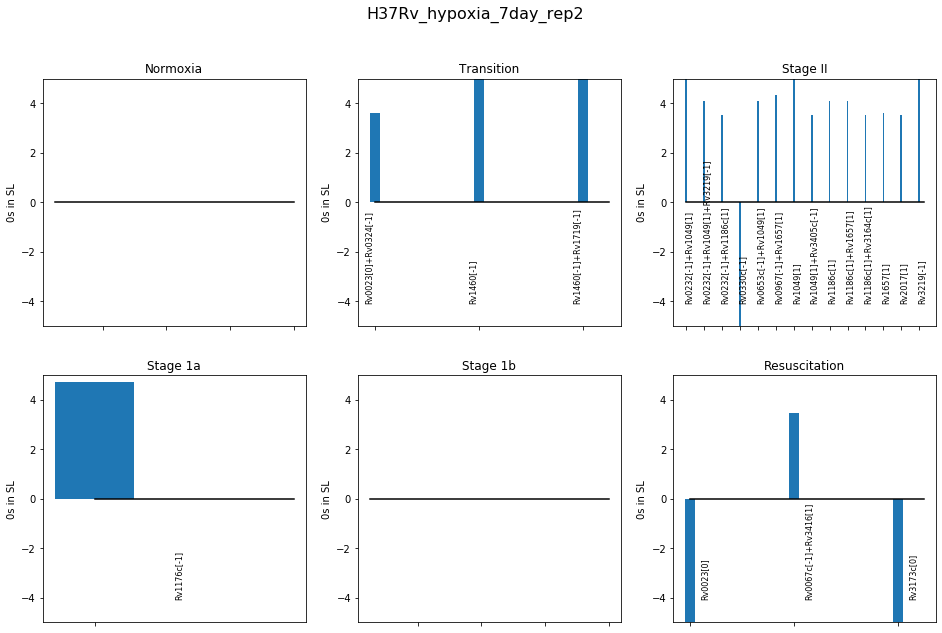

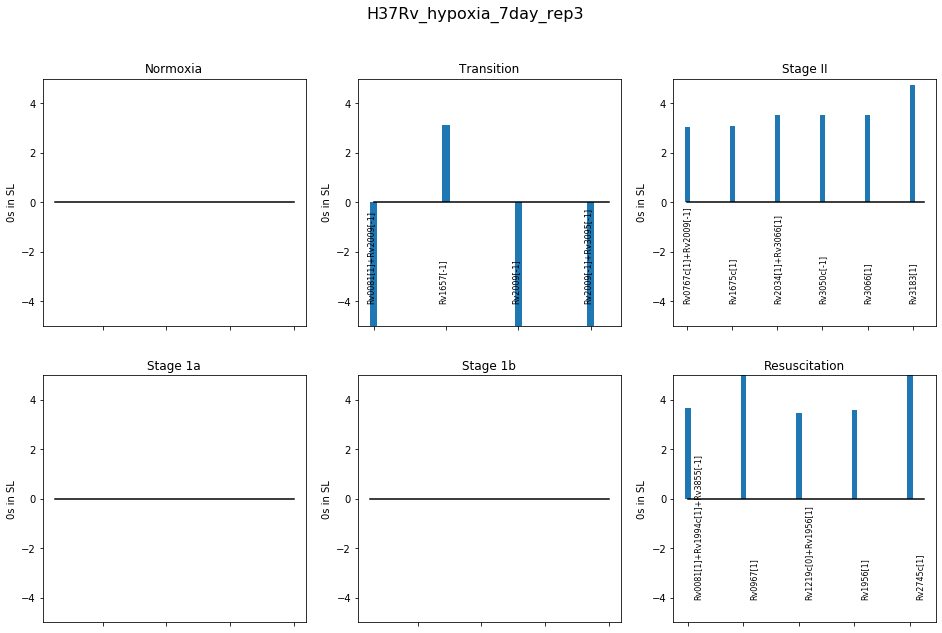

In [26]:
for instance in DF_RUSTAD.columns:
    fullProfile(DF_RUSTAD[instance], title=instance)

# Next Steps

1. Use other criteria to select the cases
   1. Prefer longer feature vectors since more specific
   1. Prefer cases that have a gene with a "hypoxia" GO term. Subset the cases to include genes for hypoxia and fatty acid.
   1. Aggregate terms if the same features appear repeatedly (e.g., only include a term if it's extension is not significant?)